# Response of Tropical Cyclones to Volcanic Eruptions

* Wenchang Yang (wenchang@princeton.edu)
* Department of Geosciences, Princeton University

In [1]:
%run -im pythonstartup

**2019-04-04T10:55:27.167516**
>>> Importing Python 3.7.2 packages...
[OK]: import sys, os, os.path, datetime, glob
[OK]: import numpy as np-1.16.2
[OK]: import matplotlib as mpl-3.0.3; backend: module://ipykernel.pylab.backend_inline
[OK]: #---import matplotlib.pyplot as plt
[OK]: #---from pylab import *
[OK]: import xarray as xr-0.12.0
[OK]: #---import netCDF4
[OK]: #---import dask
[OK]: #---import bottleneck
[OK]: import pandas as pd-0.24.2
[OK]: from mpl_toolkits.basemap import Basemap
      PROJ_LIB = /tigress/wenchang/miniconda3p7/share/proj
>>>Import packages from Wenchang Yang (wython)...
[OK]: import geoplots as gt
[OK]: from geoplots import geoplot, fxyplot, mapplot, xticksyear
[OK]: import geoxarray
[OK]: import filter
[OK]: import xlearn
[OK]: import mysignal as sig
**Done**


In [46]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['hatch.color']='g'
import xarray as xr
import pandas as pd

import geoxarray
from geoplots import mapplot, yticks2lat

from itertools import product
from cftime import DatetimeJulian
import xarray as xr

from mystats import p2t

In [302]:
def expand_ax(ax=None, scale=1.5):
    if ax is None:
        ax = plt.gca()
    x0, y0, w, h = ax.get_position().bounds
    ax.set_position([x0-w*(scale-1), y0, w*scale, h])
def shrink_ax(ax=None, scale=0.6):
    if ax is None:
        ax = plt.gca()
    x0, y0, w, h = ax.get_position().bounds
    ax.set_position([x0, y0, w*scale, h])

def scale_right(ax=None, scale=1):
    '''scale axes by moving the right side'''
    if ax is None:
        ax = plt.gca()
    x0, y0, w, h = ax.get_position().bounds
    ax.set_position([x0, y0, w*scale, h])
def scale_left(ax=None, scale=1):
    '''scale axes by moving the left side'''
    if ax is None:
        ax = plt.gca()
    x0, y0, w, h = ax.get_position().bounds
    ax.set_position([x0-w*(scale-1), y0, w*scale, h])
def axscale(ax=None, right=0, left=0, up=0, down=0):
    '''scale the axes by the four sides'''
    if ax is None:
        ax = plt.gca()
    x0, y0, w, h = ax.get_position().bounds
    w_new = w*(1 + right + left)
    h_new = h*(1 + up + down)
    x0_new = x0 - w*left
    y0_new = y0 - h*down
    ax.set_position([x0_new, y0_new, w_new, h_new])
    return ax

In [61]:
# data
new_names = dict(XAX='lon', YAX='lat', YRT='time')
data_name = 'DENSEW'
ncfile = '/tigress/gvecchi/ANALYSIS/FLOR/TCs_LUCAS/TRAJ_CTL1860_noleap/NETCDF_TRACKS/dens.nc'
da = xr.open_dataset(ncfile).rename(new_names)[data_name]
ref200 = da.sel(time=slice(11,211)).mean('time')

<IPython.core.display.Javascript object>


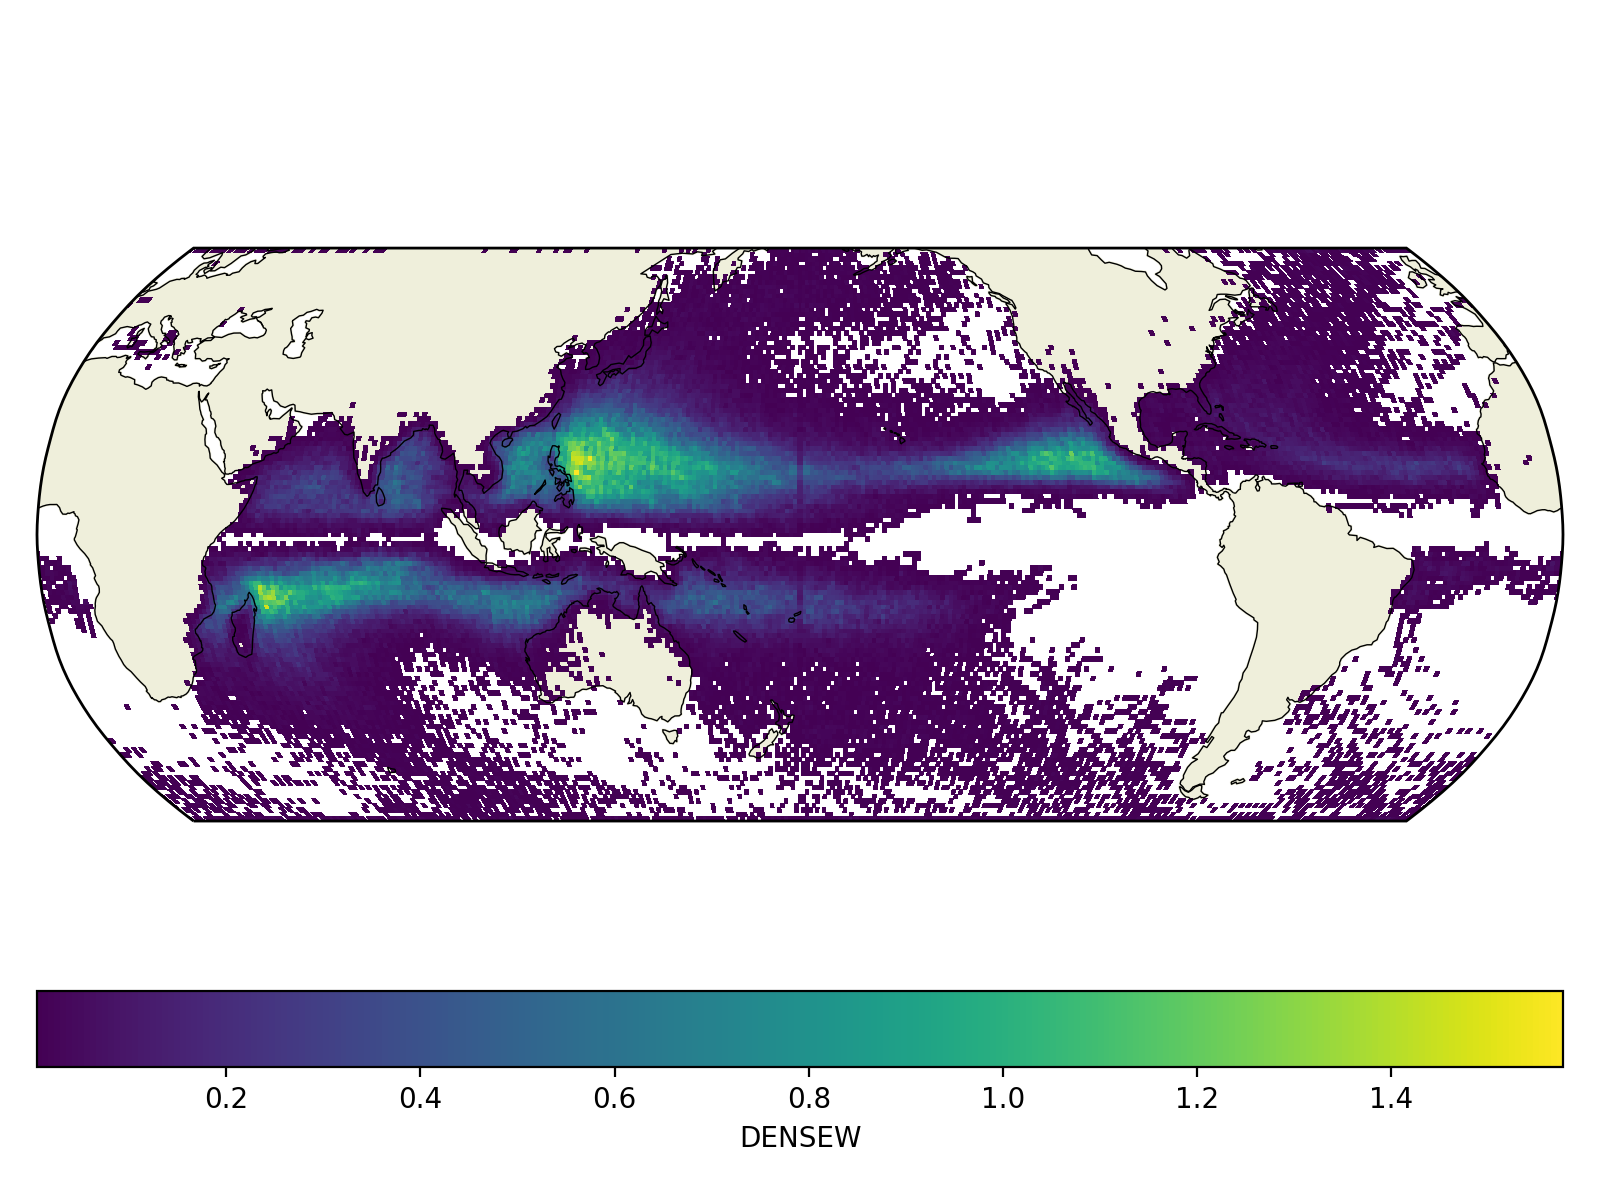

In [16]:
plt.figure(figsize=(8,6))
ref200.where(ref200>0).geo.cartoplot(cbar_kwargs={'orientation':'horizontal'},
                                    proj_kws={'central_longitude': 180},
                                    land_on=True)
# plt.gca().set_global()
plt.tight_layout()

<IPython.core.display.Javascript object>


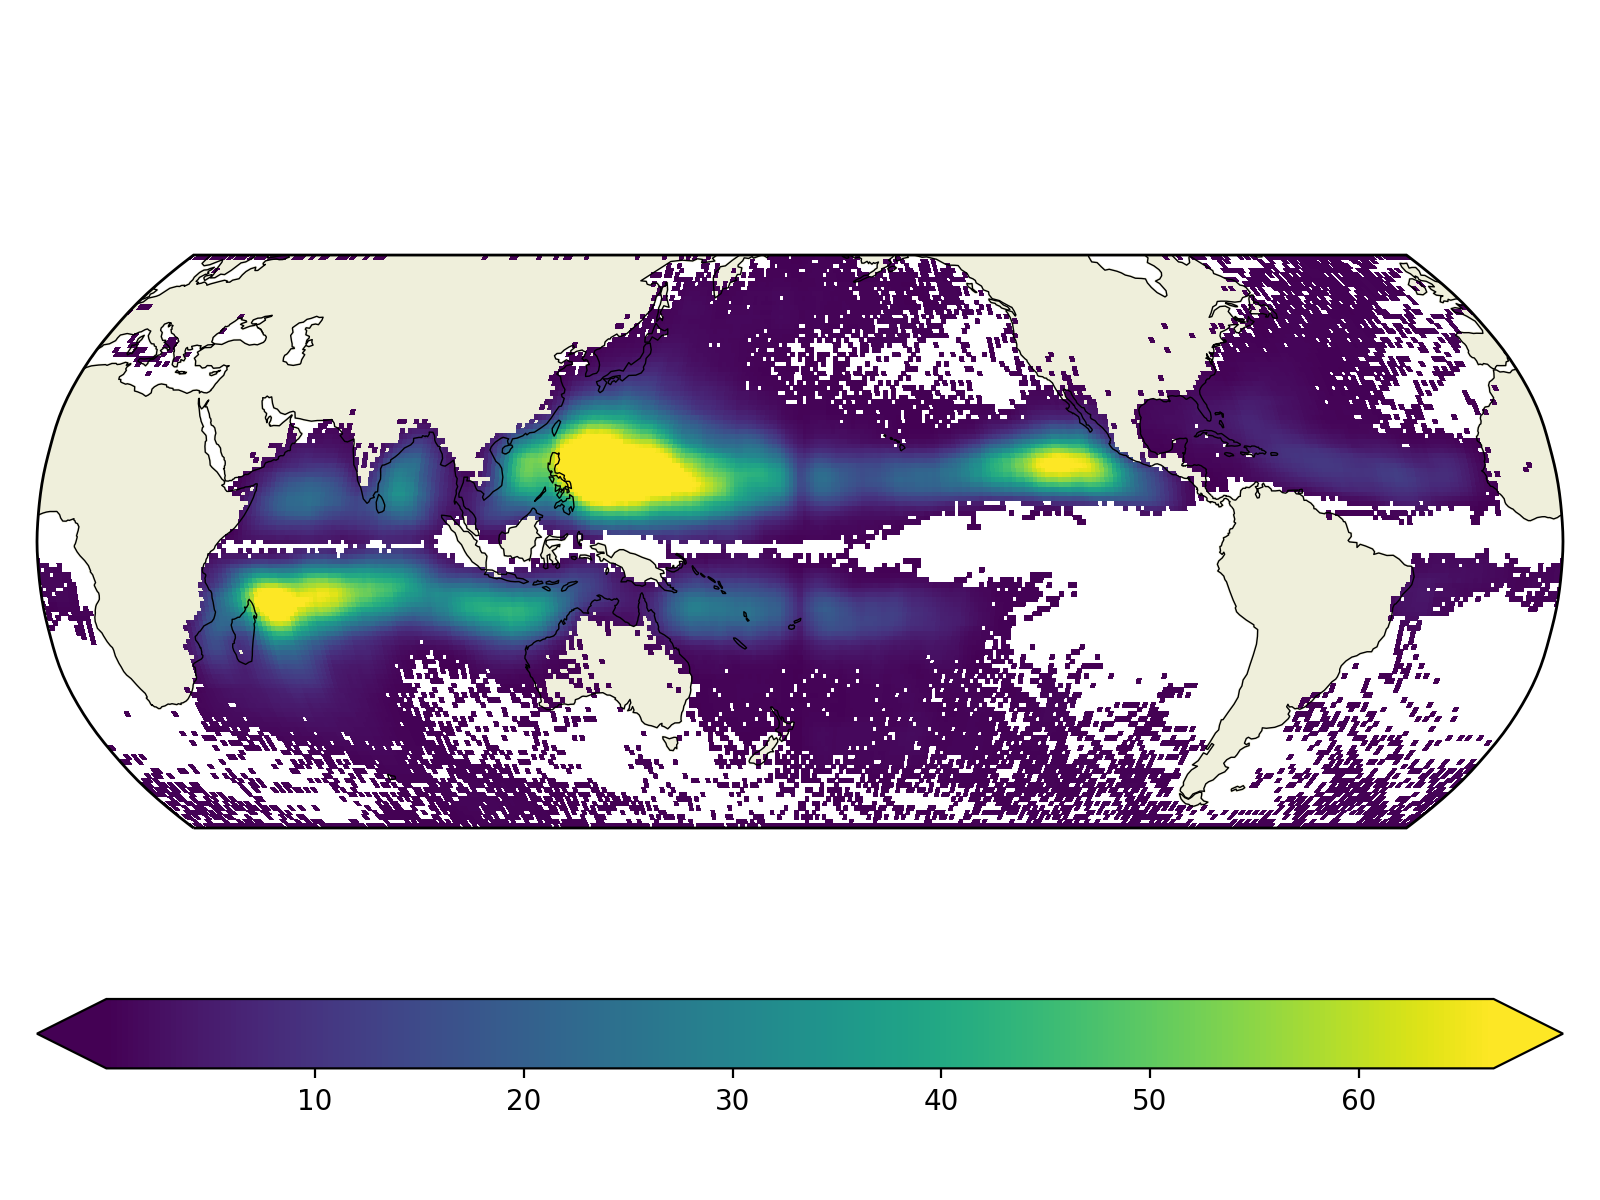

In [65]:
plt.figure(figsize=(8,6))
da.sel(time=slice(11,11+29)).mean('time') \
    .rolling(lon=9, center=True, min_periods=1).sum() \
    .rolling(lat=9, center=True, min_periods=1).sum() \
    .where(ref200>0).geo.cartoplot(cbar_kwargs={'orientation':'horizontal'},
                                    proj_kws={'central_longitude': 180},
                                    land_on=True, robust=True)
# plt.gca().set_global()
plt.tight_layout()

In [28]:
ncfiles = dict(stmaria='/tigress/gvecchi/ANALYSIS/FLOR/TCs_LUCAS/TRAJ_STMARIA_ens_noleap/NETCDF_TRACKS/dens.nc',
              agung='/tigress/gvecchi/ANALYSIS/FLOR/TCs_LUCAS/TRAJ_AGUNG_ens_noleap/NETCDF_TRACKS/dens.nc',
              pinatubo='/tigress/gvecchi/ANALYSIS/FLOR/TCs_LUCAS/TRAJ_PINATUBO_ens_noleap/NETCDF_TRACKS/dens.nc')

<IPython.core.display.Javascript object>


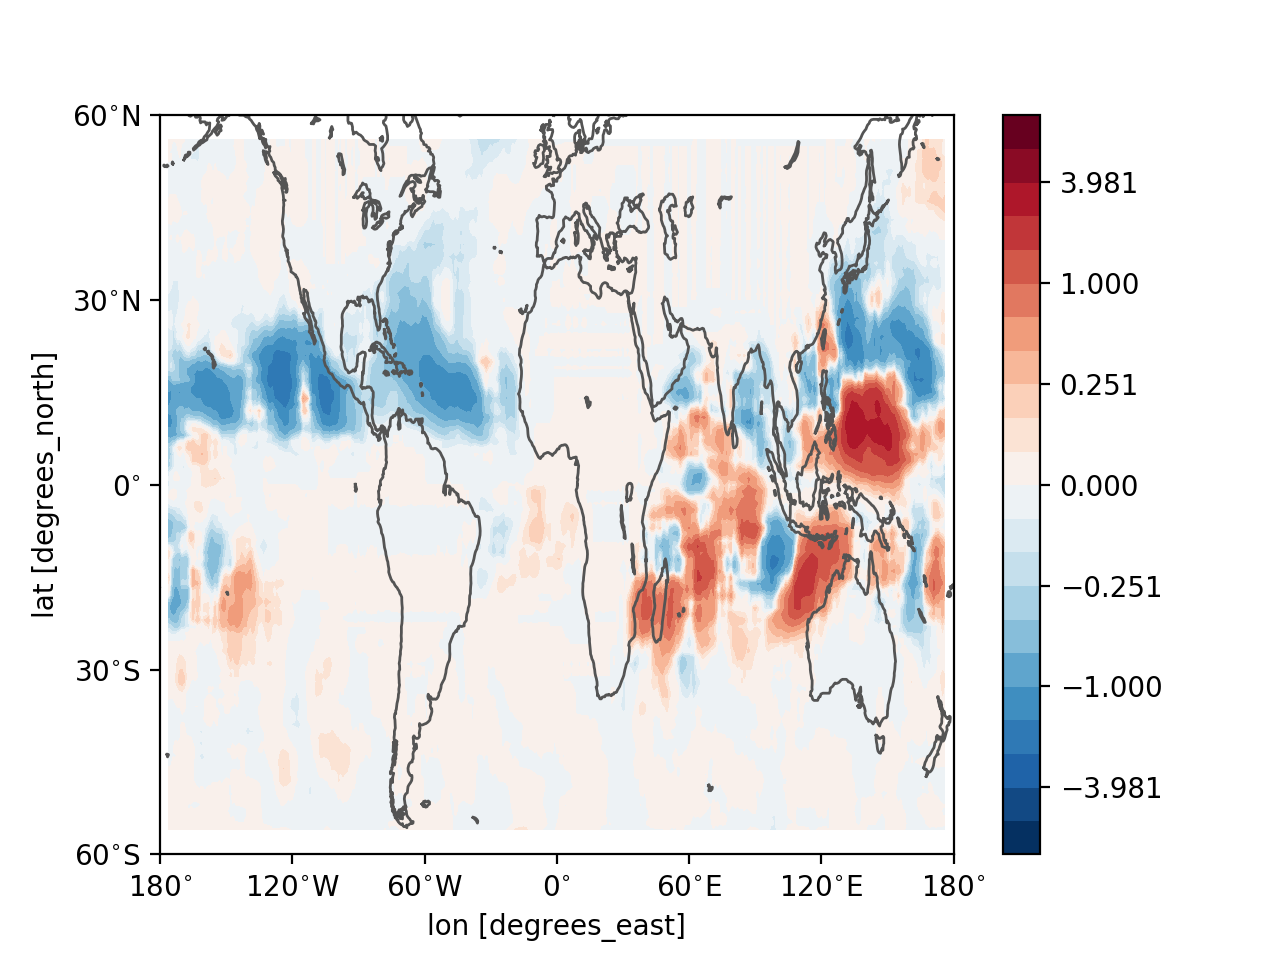

In [29]:
# levels = list(np.arange(-10, -4, 2)) \
#     + list(np.arange(-4, -1, 1)) \
#     + list(np.arange(-1, 1, 0.1)) \
#     + list(np.arange(1, 4, 1)) \
#     + list(np.arange(4, 10.1, 2))
# levels = np.arange(-2, 2.1, 0.2)
lv = 10**np.arange(-1, 1.1, .2)
levels = list(-lv[-1::-1]) + [0,] + list(lv)
da = xr.open_dataset(ncfiles['stmaria'])[data_name].rename(new_names)/30.0
da.isel(time=slice(0,3)).mean('time').pipe(lambda x: x-ref200).pipe(lambda x: x*100/4) \
    .rolling(lon=9, center=True).mean() \
    .rolling(lat=9, center=True).mean().plot.contourf(levels=levels)
mapplot()

<IPython.core.display.Javascript object>


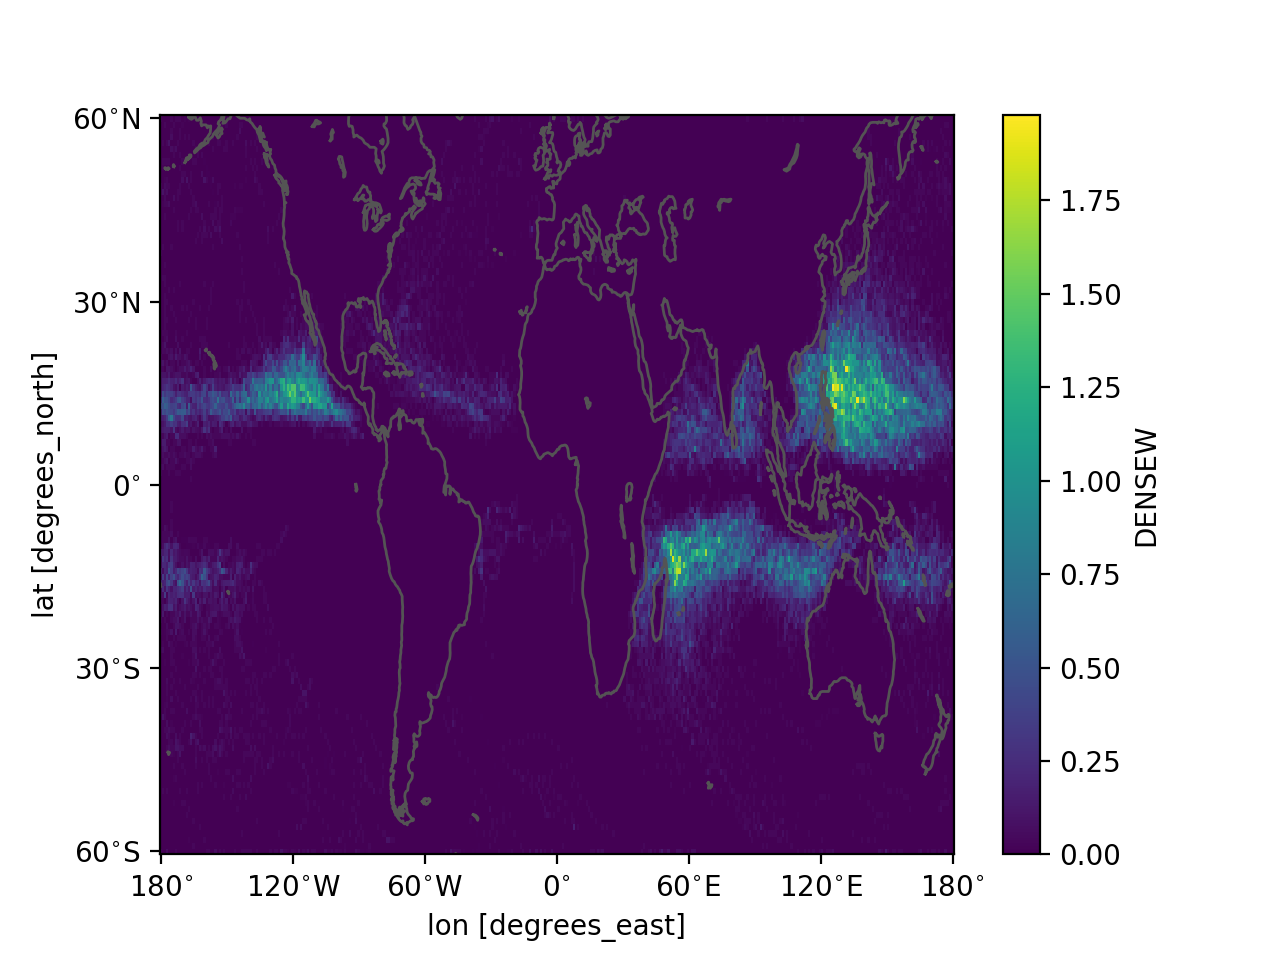

In [31]:
# data: ctl
new_names = dict(XAX='lon', YAX='lat', YRT='time')
data_name = 'DENSEW'
ncfile = '/tigress/gvecchi/ANALYSIS/FLOR/TCs_LUCAS/TRAJ_CTL1860_noleap/NETCDF_TRACKS/dens.nc'
da = xr.open_dataset(ncfile).rename(new_names)[data_name]
ens = range(1,31) #range(1, 31)
das = []
for en in ens:
    tmp = da.sel(time=slice(10+en, 10+en+4))
    tmp['time'] = range(1,6)
    das.append(tmp)
ref = xr.concat(das, dim=pd.Index(ens, name='en'))
ref.sel(time=slice(1,3)).mean(['en', 'time']).plot()
mapplot()

In [32]:
ref

<xarray.DataArray 'DENSEW' (en: 30, time: 5, lat: 121, lon: 361)>
array([[[[0., ..., 0.],
         ...,
         [0., ..., 0.]],

        ...,

        [[0., ..., 0.],
         ...,
         [0., ..., 0.]]],


       ...,


       [[[0., ..., 0.],
         ...,
         [0., ..., 0.]],

        ...,

        [[0., ..., 0.],
         ...,
         [0., ..., 0.]]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 -180.0 -179.0 -178.0 -177.0 ... 178.0 179.0 180.0
  * lat      (lat) float64 -60.0 -59.0 -58.0 -57.0 -56.0 ... 57.0 58.0 59.0 60.0
  * time     (time) int64 1 2 3 4 5
  * en       (en) int64 1 2 3 4 5 6 7 8 9 10 ... 21 22 23 24 25 26 27 28 29 30
Attributes:
    long_name:      Density of all gale-force tracks with WC
    long_name_mod:  T=0.5:500.5

In [35]:
# data: volc exps
das = dict()
for volc_name in ['stmaria', 'agung', 'pinatubo']:
    da = xr.open_dataset(ncfiles[volc_name])[data_name].rename(new_names)/30
    das[volc_name] = da

## Figure

<IPython.core.display.Javascript object>


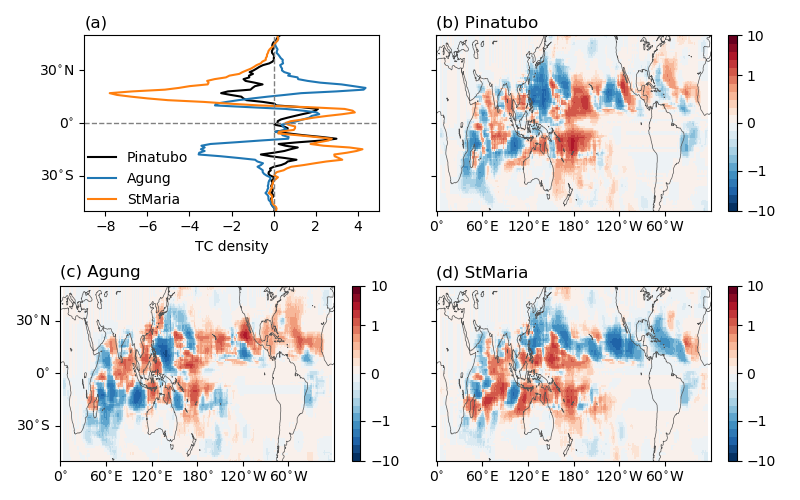

In [15]:
# fig
fig, axes = plt.subplots(2, 2, figsize=(8, 5), sharey=True)
n_years = 3
lv = 10**np.arange(-1, 1.1, .2)
levels = list(-lv[-1::-1]) + [0,] + list(lv)
coastline_width = .5
cbar_ticks = [-10, -1, 0, 1, 10]

ax = axes[0, 0]
ax.set_aspect(1/12)
# plt.sca(ax)
volc_name, tag = 'pinatubo', 'Pinatubo'
das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref.isel(time=slice(0, n_years)).mean(['en', 'time'])) \
    .sum('lon') \
    .rolling(lat=9, center=True).mean() \
    .plot(ax=ax, y='lat', label=tag, lw=1.5, color='k')
volc_name, tag = 'agung', 'Agung'
das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref.isel(time=slice(0, n_years)).mean(['en', 'time'])) \
    .sum('lon') \
    .rolling(lat=9, center=True).mean() \
    .plot(ax=ax, y='lat', label=tag, lw=1.5, color='C0')
volc_name, tag = 'stmaria', 'StMaria'
das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref.isel(time=slice(0, n_years)).mean(['en', 'time'])) \
    .sum('lon') \
    .rolling(lat=9, center=True).mean() \
    .plot(ax=ax, y='lat', label=tag, lw=1.5, color='C1')
ax.legend(loc='lower left', bbox_to_anchor=(-.03,-.05))
ax.set_ylim(-50, 50)
ax.set_ylabel('')
# ax.grid('on')
ax.set_title('(a)', loc='left')
ax.set_xlabel('TC density')
ax.set_xlim(-9,5)
# yticks2lat(np.arange(-45,46,15))
ax.axhline(0, color='gray', lw=1, ls='--')
ax.axvline(0, color='gray', lw=1, ls='--')

ax = axes[0, 1]
volc_name = 'pinatubo'
da = das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref.isel(time=slice(0, n_years)).mean(['en', 'time'])).pipe(lambda x: x/4)
da = xr.concat([da.sel(lon=slice(0, 180)), da.sel(lon=slice(-179, 0))], dim='lon')
da['lon'] = np.arange(0, 361)
da.rolling(lon=10, center=True).sum() \
    .rolling(lat=10, center=True).sum() \
    .plot(ax=ax, levels=levels, cbar_kwargs={'ticks': cbar_ticks}, rasterized=True)
mapplot(ax=ax, lon=da.lon, lat=(-50, 50), linewidth=coastline_width)
ax.set_xlabel('')
ax.set_ylabel('')
plt.title('(b) Pinatubo', loc='left')

ax = axes[1, 0]
volc_name = 'agung'
da = das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref.isel(time=slice(0, n_years)).mean(['en', 'time'])).pipe(lambda x: x/4)
da = xr.concat([da.sel(lon=slice(0, 180)), da.sel(lon=slice(-179, 0))], dim='lon')
da['lon'] = np.arange(0, 361)
da.rolling(lon=10, center=True).sum() \
    .rolling(lat=10, center=True).sum() \
    .plot(ax=ax, levels=levels, cbar_kwargs={'ticks': cbar_ticks}, rasterized=True)
mapplot(ax=ax, lon=da.lon, lat=(-50, 50), linewidth=coastline_width)
ax.set_xlabel('')
ax.set_ylabel('')
plt.title('(c) Agung', loc='left')



ax = axes[1, 1]
plt.sca(ax)
volc_name = 'stmaria'
da = das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref.isel(time=slice(0, n_years)).mean(['en', 'time'])).pipe(lambda x: x/4)
da = xr.concat([da.sel(lon=slice(0, 180)), da.sel(lon=slice(-179, 0))], dim='lon')
da['lon'] = np.arange(0, 361)
da.rolling(lon=10, center=True).sum() \
    .rolling(lat=10, center=True).sum() \
    .plot(ax=ax, levels=levels, cbar_kwargs={'ticks': cbar_ticks}, rasterized=True)
ax.set_yticks(np.arange(-45,46,15))
mapplot(ax=ax, lon=da.lon, lat=(-50, 50), linewidth=coastline_width)
ax.set_xlabel('')
ax.set_ylabel('')
plt.title('(d) StMaria', loc='left')
# yticks2lat(np.arange(-45,46,15))



plt.tight_layout()

figname = 'figs/fig_tc.pdf'
plt.savefig(figname)

In [130]:
n_ens = 30
# lambda x: x/4: per year -> per season
func_per_season = lambda x: x/4
sx = ref.isel(time=slice(0, n_years)).mean('time') \
    .rolling(lon=10, center=True).sum() \
    .rolling(lat=10, center=True).sum() \
    .pipe(func_per_season) \
    .mean('lon').std('en')
spread = p2t(0.1, df=n_ens-1) * sx * n_ens**(-1/2) * 2**(1/2)
spread

<xarray.DataArray (lat: 121)>
array([     nan,      nan,      nan,      nan,      nan, 0.022752, 0.014622,
       0.015785, 0.01474 , 0.014599, 0.014311, 0.015177, 0.014055, 0.015367,
       0.014943, 0.015759, 0.019482, 0.021352, 0.023156, 0.027518, 0.030575,
       0.033233, 0.032962, 0.028825, 0.030618, 0.033019, 0.031253, 0.031321,
       0.031851, 0.032153, 0.030113, 0.028646, 0.030662, 0.033784, 0.040023,
       0.047836, 0.050724, 0.058305, 0.066957, 0.0823  , 0.104526, 0.126764,
       0.141396, 0.14289 , 0.138392, 0.150131, 0.14451 , 0.155397, 0.154921,
       0.152251, 0.151276, 0.140774, 0.134457, 0.120508, 0.113934, 0.093374,
       0.084396, 0.06122 , 0.053376, 0.058733, 0.057392, 0.075004, 0.100758,
       0.129983, 0.136794, 0.157263, 0.182508, 0.212901, 0.242538, 0.255137,
       0.262103, 0.257425, 0.264877, 0.254556, 0.253972, 0.242527, 0.239194,
       0.227067, 0.196433, 0.176563, 0.159436, 0.151647, 0.132622, 0.123441,
       0.105831, 0.090528, 0.074085, 0.075405,

In [213]:
mean_value = ref.isel(time=slice(0, n_years)).mean('time') \
    .rolling(lon=10, center=True).sum() \
    .rolling(lat=10, center=True).sum() \
    .pipe(func_per_season) \
    .mean('lon').mean('en')
mean_value

<xarray.DataArray (lat: 121)>
array([     nan,      nan,      nan,      nan,      nan, 0.085496, 0.061955,
       0.067164, 0.067716, 0.071031, 0.071512, 0.072514, 0.078046, 0.086229,
       0.093655, 0.098161, 0.104553, 0.108231, 0.115554, 0.123761, 0.134833,
       0.143497, 0.153385, 0.161229, 0.169997, 0.180776, 0.190483, 0.205682,
       0.221054, 0.238842, 0.268892, 0.309241, 0.345486, 0.392535, 0.460243,
       0.546054, 0.648232, 0.799376, 1.010211, 1.27118 , 1.634832, 2.067605,
       2.553843, 3.004001, 3.424779, 3.796022, 4.086253, 4.285637, 4.310424,
       4.216611, 3.95251 , 3.556368, 3.068648, 2.579261, 2.075624, 1.596528,
       1.181621, 0.816619, 0.575458, 0.443979, 0.413502, 0.539646, 0.760448,
       1.065688, 1.441627, 1.878267, 2.386411, 2.999463, 3.711324, 4.499969,
       5.325521, 5.95872 , 6.467266, 6.839046, 7.032853, 7.084879, 7.006724,
       6.733774, 6.263818, 5.627904, 4.8558  , 4.152012, 3.49229 , 2.890309,
       2.401965, 1.989433, 1.615901, 1.31351 ,

<IPython.core.display.Javascript object>


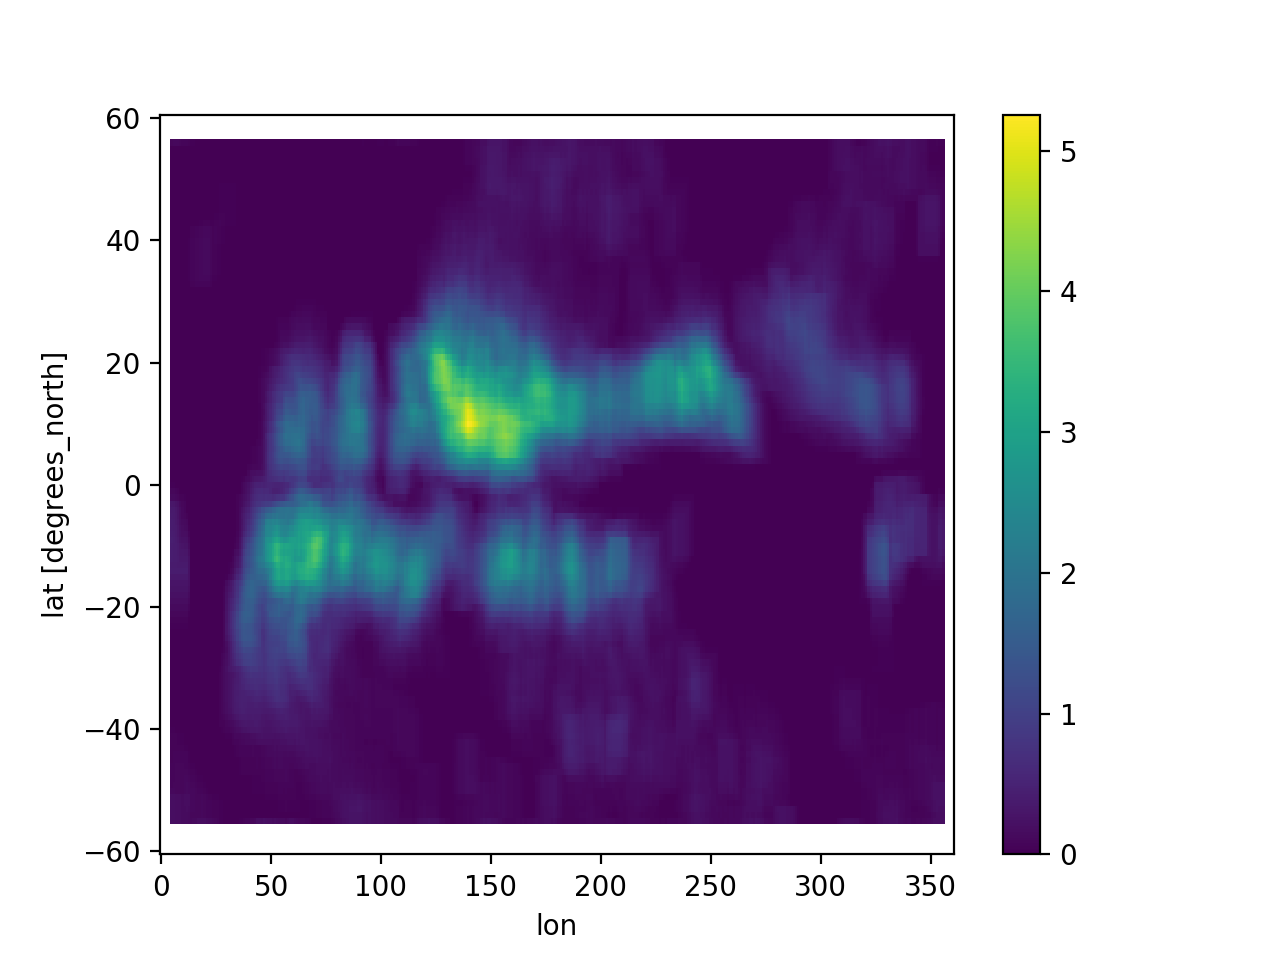

In [214]:
da = xr.concat([ref.sel(lon=slice(0, 180)), ref.sel(lon=slice(-179, 0))], dim='lon')
da['lon'] = np.arange(0, 361)
sx = da.isel(time=0, drop=True) \
    .rolling(lon=10, center=True).sum() \
    .rolling(lat=10, center=True).sum() \
    .pipe(func_per_season) \
    .std('en')
spread_map = p2t(0.1, df=n_ens-1) * sx * n_ens**(-1/2) * 2**(1/2)
spread_map.plot()

<IPython.core.display.Javascript object>


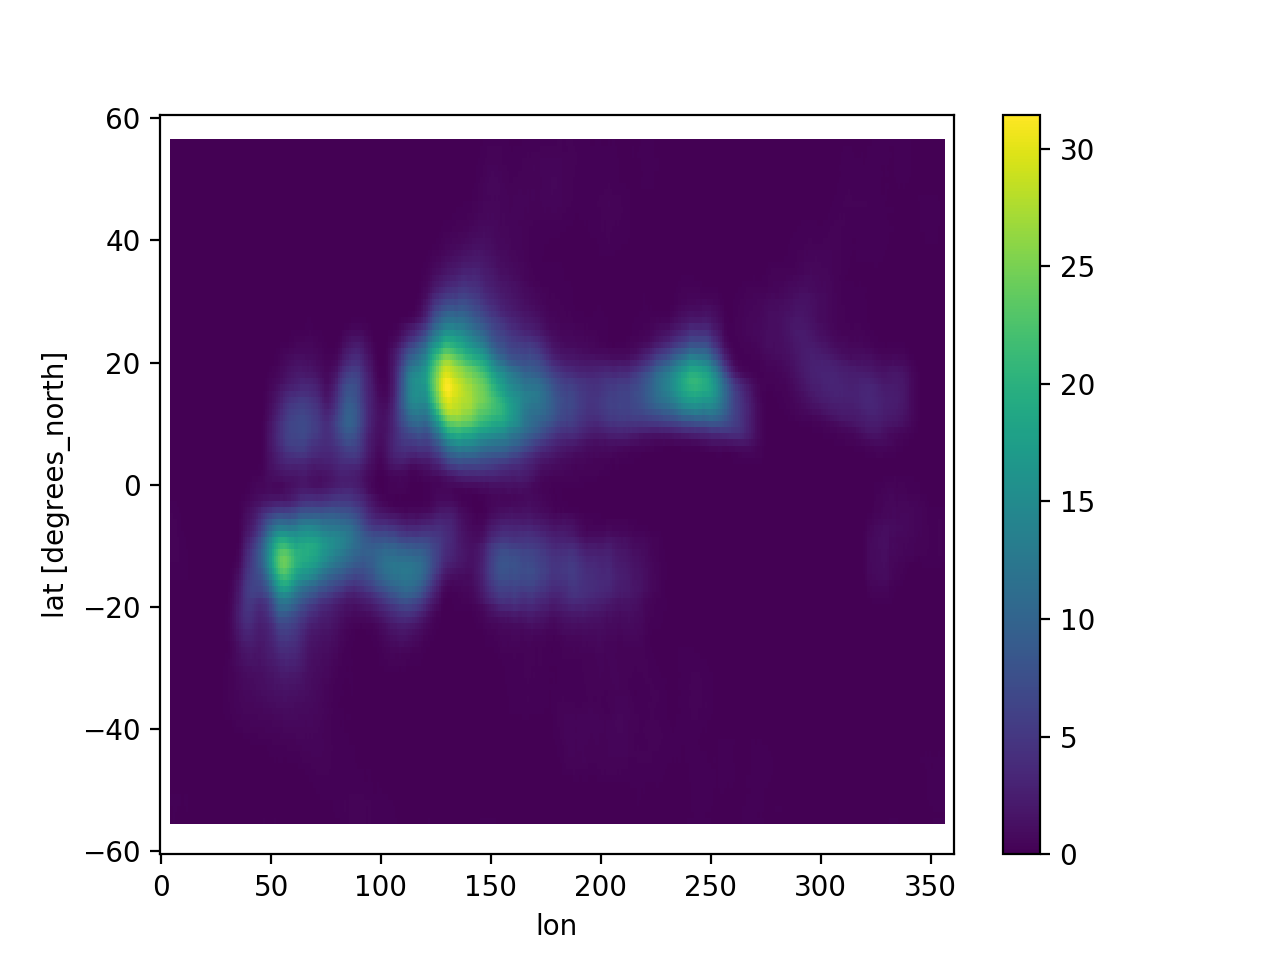

In [215]:
da = xr.concat([ref.sel(lon=slice(0, 180)), ref.sel(lon=slice(-179, 0))], dim='lon')
da['lon'] = np.arange(0, 361)
mean_value_map = da.isel(time=0, drop=True) \
    .rolling(lon=10, center=True).sum() \
    .rolling(lat=10, center=True).sum() \
    .pipe(func_per_season) \
    .mean('en')
mean_value_map.plot()

<IPython.core.display.Javascript object>


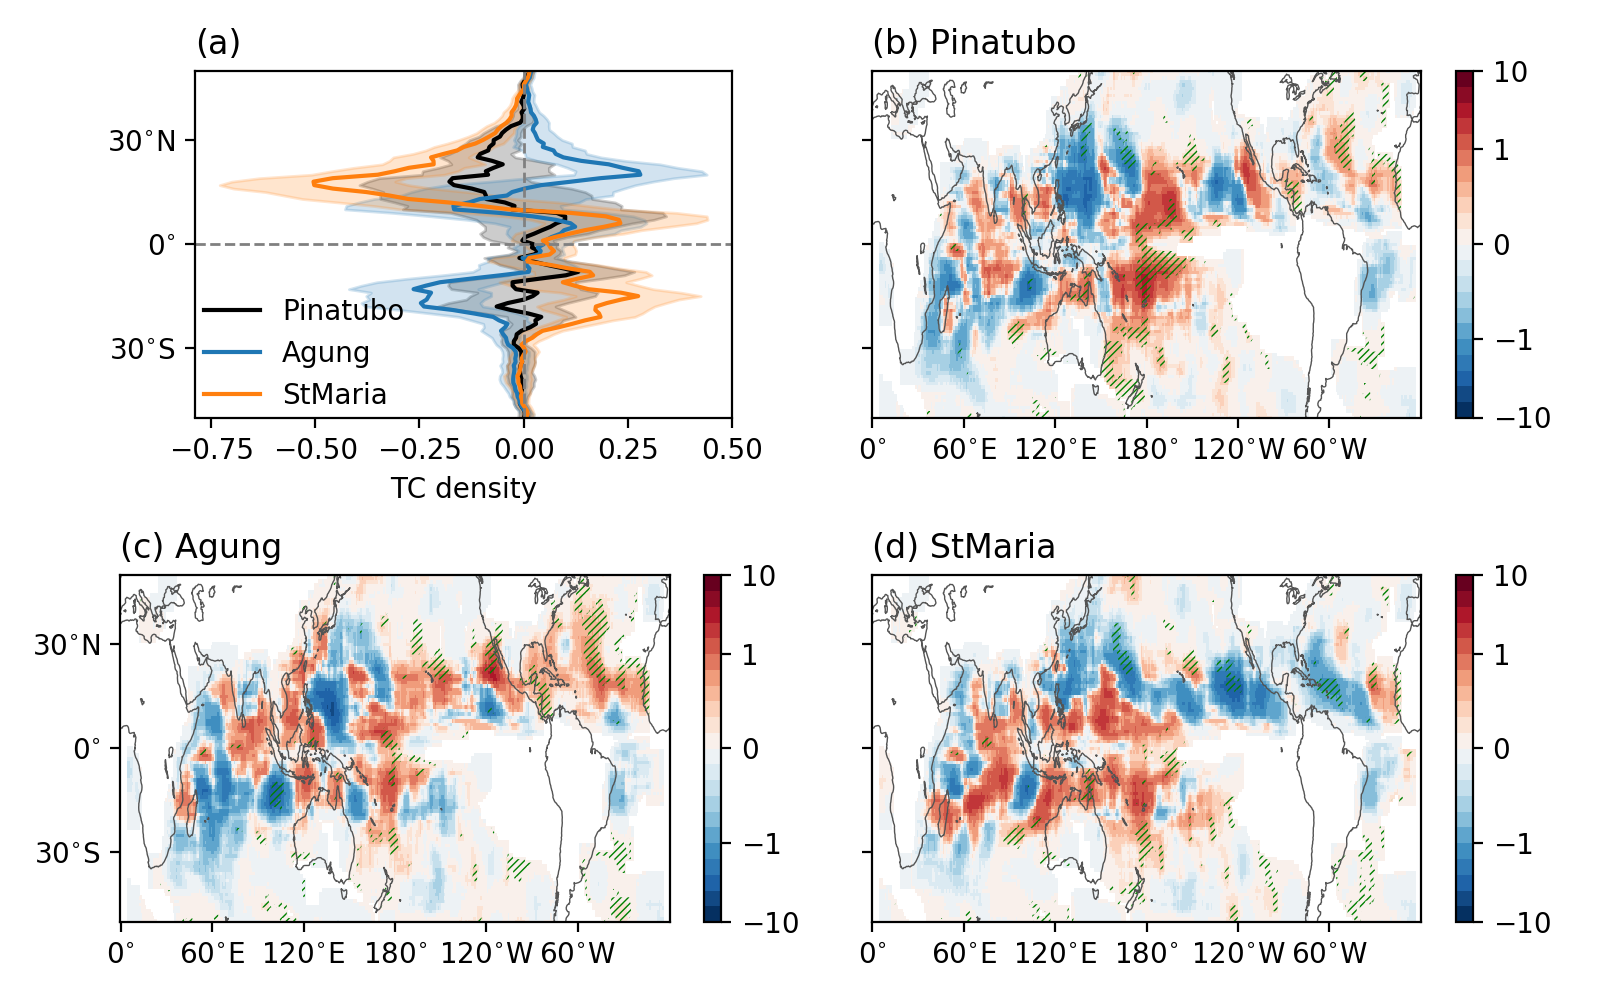

In [156]:
# fig revision_1 spread
fig, axes = plt.subplots(2, 2, figsize=(8, 5), sharey=True)
n_years = 3
lv = 10**np.arange(-1, 1.1, .2)
levels = list(-lv[-1::-1]) + [0,] + list(lv)
coastline_width = .5
cbar_ticks = [-10, -1, 0, 1, 10]

alpha=0.2
hatches = ['/////////']

ax = axes[0, 0]
# plt.sca(ax)
ax.set_aspect(1/120)
# plt.sca(ax)
volc_name, tag = 'pinatubo', 'Pinatubo'
ts = das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref.isel(time=slice(0, n_years)).mean(['en', 'time'])) \
    .rolling(lon=10, center=True).sum() \
    .rolling(lat=10, center=True).sum() \
    .pipe(func_per_season) \
    .mean('lon')
ts.plot(ax=ax, y='lat', label=tag, lw=1.5, color='k')
ax.fill_betweenx(y=ts.lat, x1=ts-spread, x2=ts+spread, color='k', alpha=alpha)
volc_name, tag = 'agung', 'Agung'
ts = das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref.isel(time=slice(0, n_years)).mean(['en', 'time'])) \
    .rolling(lon=10, center=True).sum() \
    .rolling(lat=10, center=True).sum() \
    .pipe(func_per_season) \
    .mean('lon')
ts.plot(ax=ax, y='lat', label=tag, lw=1.5, color='C0')
ax.fill_betweenx(y=ts.lat, x1=ts-spread, x2=ts+spread, color='C0', alpha=alpha)
volc_name, tag = 'stmaria', 'StMaria'
ts = das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref.isel(time=slice(0, n_years)).mean(['en', 'time'])) \
    .rolling(lon=10, center=True).sum() \
    .rolling(lat=10, center=True).sum() \
    .pipe(func_per_season) \
    .mean('lon')
ts.plot(ax=ax, y='lat', label=tag, lw=1.5, color='C1')
ax.fill_betweenx(y=ts.lat, x1=ts-spread, x2=ts+spread, color='C1', alpha=alpha)
ax.legend(loc='lower left', bbox_to_anchor=(-.03,-.05))
ax.autoscale()
ax.set_ylim(-50, 50)
ax.set_ylabel('')
# ax.grid('on')
ax.set_title('(a)', loc='left')
ax.set_xlabel('TC density')
# ax.set_xlim(-9,5)
# yticks2lat(np.arange(-45,46,15))
ax.axhline(0, color='gray', lw=1, ls='--')
ax.axvline(0, color='gray', lw=1, ls='--')

ax = axes[0, 1]
volc_name = 'pinatubo'
da = das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref.isel(time=slice(0, n_years)).mean(['en', 'time'])).pipe(lambda x: x/4)
da = xr.concat([da.sel(lon=slice(0, 180)), da.sel(lon=slice(-179, 0))], dim='lon')
da['lon'] = np.arange(0, 361)
da = da.rolling(lon=10, center=True).sum() \
    .rolling(lat=10, center=True).sum()
L = np.abs(da) > spread_map
L = L & (spread_map>0)
da.where(spread_map>0).plot(ax=ax, levels=levels, cbar_kwargs={'ticks': cbar_ticks}, rasterized=True)
da.where(L).pipe(lambda x: x*0).plot.contourf(ax=ax, colors='none', hatches=hatches, 
                                              add_colorbar=False)
mapplot(ax=ax, lon=da.lon, lat=(-50, 50), linewidth=coastline_width)
ax.set_xlabel('')
ax.set_ylabel('')
plt.title('(b) Pinatubo', loc='left')

ax = axes[1, 0]
volc_name = 'agung'
da = das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref.isel(time=slice(0, n_years)).mean(['en', 'time'])).pipe(lambda x: x/4)
da = xr.concat([da.sel(lon=slice(0, 180)), da.sel(lon=slice(-179, 0))], dim='lon')
da['lon'] = np.arange(0, 361)
da = da.rolling(lon=10, center=True).sum() \
    .rolling(lat=10, center=True).sum()
L = np.abs(da) > spread_map
L = L & (spread_map>0)
da.where(spread_map>0).plot(ax=ax, levels=levels, cbar_kwargs={'ticks': cbar_ticks}, rasterized=True)
da.where(L).pipe(lambda x: x*0).plot.contourf(ax=ax, colors='none', hatches=hatches, 
                                              add_colorbar=False)
mapplot(ax=ax, lon=da.lon, lat=(-50, 50), linewidth=coastline_width)
ax.set_xlabel('')
ax.set_ylabel('')
plt.title('(c) Agung', loc='left')



ax = axes[1, 1]
plt.sca(ax)
volc_name = 'stmaria'
da = das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref.isel(time=slice(0, n_years)).mean(['en', 'time'])).pipe(lambda x: x/4)
da = xr.concat([da.sel(lon=slice(0, 180)), da.sel(lon=slice(-179, 0))], dim='lon')
da['lon'] = np.arange(0, 361)
da = da.rolling(lon=10, center=True).sum() \
    .rolling(lat=10, center=True).sum()
L = np.abs(da) > spread_map
L = L & (spread_map>0)
da.where(spread_map>0).plot(ax=ax, levels=levels, cbar_kwargs={'ticks': cbar_ticks}, rasterized=True)
da.where(L).pipe(lambda x: x*0).plot.contourf(ax=ax, colors='none', hatches=hatches, 
                                              add_colorbar=False)
ax.set_yticks(np.arange(-45,46,15))
mapplot(ax=ax, lon=da.lon, lat=(-50, 50), linewidth=coastline_width)
ax.set_xlabel('')
ax.set_ylabel('')
plt.title('(d) StMaria', loc='left')
# yticks2lat(np.arange(-45,46,15))



plt.tight_layout()

figname = 'figs/fig_tc.pdf'
plt.savefig(figname)

<IPython.core.display.Javascript object>


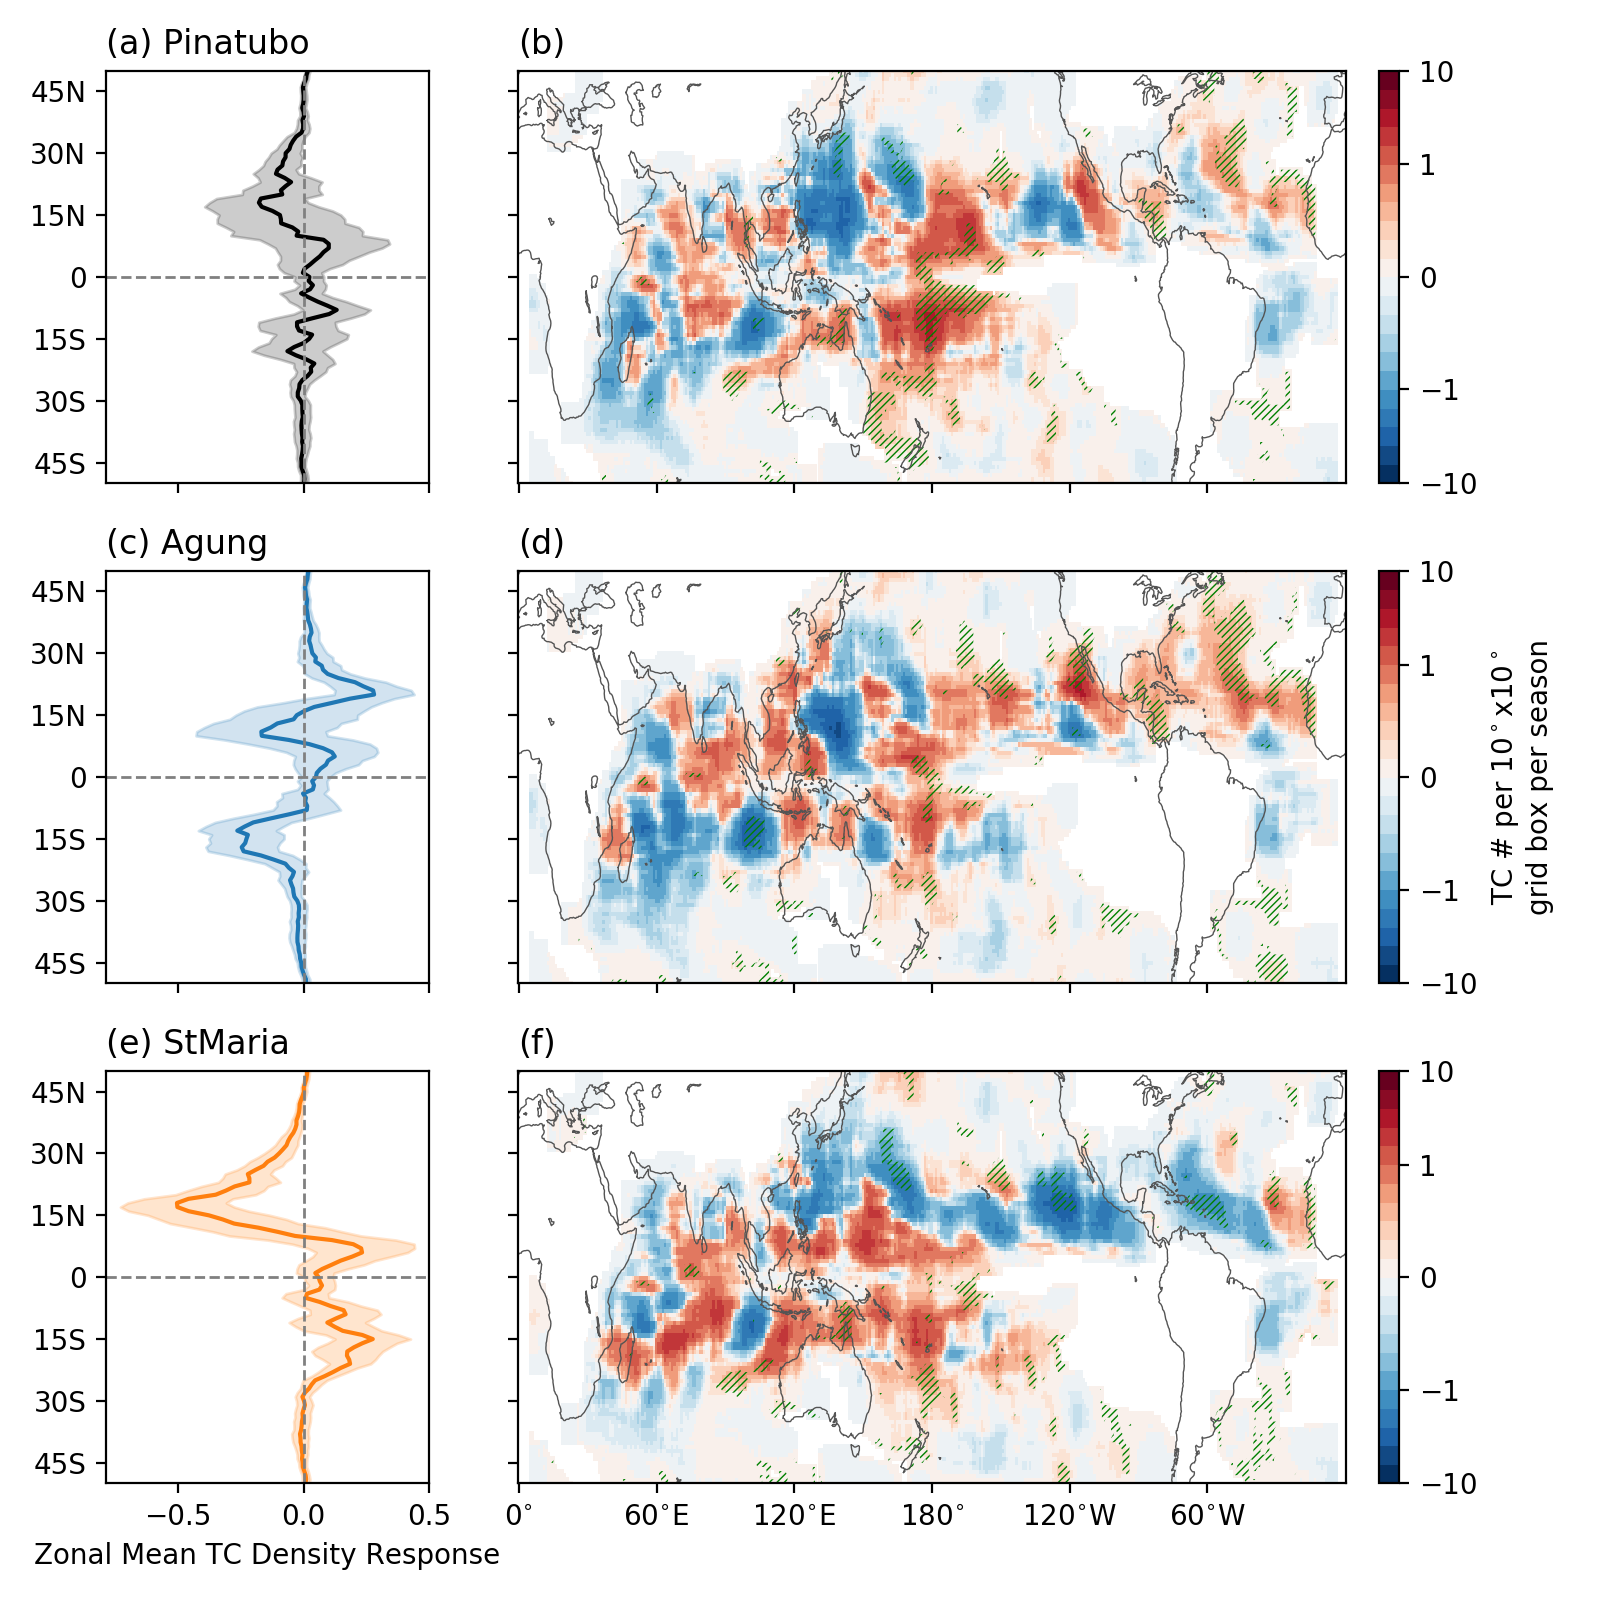

In [366]:
# fig revision_1 spread 3x2 subplots
def expand_ax(ax, scale=1.6):
    x0, y0, w, h = ax.get_position().bounds
    ax.set_position([x0-w*(scale-1), y0, w*scale, h])
def shrink_ax(ax, scale=0.6):
    x0, y0, w, h = ax.get_position().bounds
    ax.set_position([x0, y0, w*scale, h])
fig, axes = plt.subplots(3, 2, figsize=(8, 8), sharey=True, sharex='col')
n_years = 3
lv = 10**np.arange(-1, 1.1, .2)
levels = list(-lv[-1::-1]) + [0,] + list(lv)
coastline_width = .5
cbar_ticks = [-10, -1, 0, 1, 10]

# aspect = 1/120

alpha=0.2
hatches = ['/////////']

ax = axes[0, 0]
# plt.sca(ax)
# ax.set_aspect(aspect)
# plt.sca(ax)
volc_name, tag = 'pinatubo', 'Pinatubo'
ts = das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref.isel(time=slice(0, n_years)).mean(['en', 'time'])) \
    .rolling(lon=10, center=True).sum() \
    .rolling(lat=10, center=True).sum() \
    .pipe(func_per_season) \
    .mean('lon')
ts.plot(ax=ax, y='lat', label=tag, lw=1.5, color='k')
ax.fill_betweenx(y=ts.lat, x1=ts-spread, x2=ts+spread, color='k', alpha=alpha)
ax.autoscale()
ax.set_ylim(-50, 50)
ax.set_ylabel('')
# ax.grid('on')
ax.set_title(f'(a) {tag}', loc='left')
# ax.set_xlabel('TC density')
# ax.set_xlim(-9,5)
# yticks2lat(np.arange(-45,46,15))
# yticks2lat(np.arange(-30,31,30))
ax.set_yticks(range(-45,46,15))
ax.axhline(0, color='gray', lw=1, ls='--')
ax.axvline(0, color='gray', lw=1, ls='--')
# shrink_ax(ax)


ax = axes[1, 0]
# plt.sca(ax)
# ax.set_aspect(aspect)
# plt.sca(ax)
volc_name, tag = 'agung', 'Agung'
ts = das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref.isel(time=slice(0, n_years)).mean(['en', 'time'])) \
    .rolling(lon=10, center=True).sum() \
    .rolling(lat=10, center=True).sum() \
    .pipe(func_per_season) \
    .mean('lon')
ts.plot(ax=ax, y='lat', label=tag, lw=1.5, color='C0')
ax.fill_betweenx(y=ts.lat, x1=ts-spread, x2=ts+spread, color='C0', alpha=alpha)
ax.autoscale()
ax.set_ylim(-50, 50)
ax.set_ylabel('')
# ax.grid('on')
ax.set_title(f'(c) {tag}', loc='left')
# ax.set_xlabel('TC density')
# ax.set_xlim(-9,5)
# yticks2lat(np.arange(-45,46,15))
# yticks2lat(np.arange(-30,31,30))
ax.set_yticks(range(-45,46,15))
ax.axhline(0, color='gray', lw=1, ls='--')
ax.axvline(0, color='gray', lw=1, ls='--')
# shrink_ax(ax)

ax = axes[2, 0]
# plt.sca(ax)
# ax.set_aspect(aspect)
# plt.sca(ax)
volc_name, tag = 'stmaria', 'StMaria'
ts = das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref.isel(time=slice(0, n_years)).mean(['en', 'time'])) \
    .rolling(lon=10, center=True).sum() \
    .rolling(lat=10, center=True).sum() \
    .pipe(func_per_season) \
    .mean('lon')
ts.plot(ax=ax, y='lat', label=tag, lw=1.5, color='C1')
ax.fill_betweenx(y=ts.lat, x1=ts-spread, x2=ts+spread, color='C1', alpha=alpha)
# ax.legend(loc='lower left', bbox_to_anchor=(-.03,-.05))
ax.autoscale()
ax.set_ylim(-50, 50)
ax.set_ylabel('')
# ax.grid('on')
ax.set_title(f'(e) {tag}', loc='left')
ax.set_xlabel('Zonal Mean TC Density Response')
# ax.set_xlim(-9,5)
# yticks2lat(np.arange(-30,31,30))
ax.set_yticks(range(-45,46,15))
ax.axhline(0, color='gray', lw=1, ls='--')
ax.axvline(0, color='gray', lw=1, ls='--')
# shrink_ax(ax)

ax = axes[0, 1]
volc_name = 'pinatubo'
da = das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref.isel(time=slice(0, n_years)).mean(['en', 'time'])).pipe(lambda x: x/4)
da = xr.concat([da.sel(lon=slice(0, 180)), da.sel(lon=slice(-179, 0))], dim='lon')
da['lon'] = np.arange(0, 361)
da = da.rolling(lon=10, center=True).sum() \
    .rolling(lat=10, center=True).sum()
L = np.abs(da) > spread_map
L = L & (spread_map>0)
da.where(spread_map>0).plot(ax=ax, levels=levels, cbar_kwargs={'ticks': cbar_ticks}, rasterized=True)
da.where(L).pipe(lambda x: x*0).plot.contourf(ax=ax, colors='none', hatches=hatches, 
                                              add_colorbar=False)
mapplot(ax=ax, lon=da.lon, lat=(-50, 50), linewidth=coastline_width)
ax.set_xlabel('')
ax.set_ylabel('')
plt.title('(b)', loc='left')
# expand_ax(ax)

ax = axes[1, 1]
volc_name = 'agung'
da = das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref.isel(time=slice(0, n_years)).mean(['en', 'time'])).pipe(lambda x: x/4)
da = xr.concat([da.sel(lon=slice(0, 180)), da.sel(lon=slice(-179, 0))], dim='lon')
da['lon'] = np.arange(0, 361)
da = da.rolling(lon=10, center=True).sum() \
    .rolling(lat=10, center=True).sum()
L = np.abs(da) > spread_map
L = L & (spread_map>0)
da.where(spread_map>0).rename('TC # per 10$^\circ$x10$^\circ$ grid box per season').plot(ax=ax, levels=levels, cbar_kwargs={'ticks': cbar_ticks}, rasterized=True)
da.where(L).pipe(lambda x: x*0).plot.contourf(ax=ax, colors='none', hatches=hatches, 
                                              add_colorbar=False)
mapplot(ax=ax, lon=da.lon, lat=(-50, 50), linewidth=coastline_width)
ax.set_xlabel('')
ax.set_ylabel('')
plt.title('(d)', loc='left')
# expand_ax(ax)



ax = axes[2, 1]
plt.sca(ax)
volc_name = 'stmaria'
da = das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref.isel(time=slice(0, n_years)).mean(['en', 'time'])).pipe(lambda x: x/4)
da = xr.concat([da.sel(lon=slice(0, 180)), da.sel(lon=slice(-179, 0))], dim='lon')
da['lon'] = np.arange(0, 361)
da = da.rolling(lon=10, center=True).sum() \
    .rolling(lat=10, center=True).sum()
L = np.abs(da) > spread_map
L = L & (spread_map>0)
da.where(spread_map>0).plot(ax=ax, levels=levels, cbar_kwargs={'ticks': cbar_ticks}, rasterized=True)
da.where(L).pipe(lambda x: x*0).plot.contourf(ax=ax, colors='none', hatches=hatches, 
                                              add_colorbar=False)
mapplot(ax=ax, lon=da.lon, lat=(-50, 50), linewidth=coastline_width)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticks(np.arange(-45,46,15))
ax.set_yticklabels(['45S', '30S', '15S', '0', '15N', '30N', '45N'])
plt.title('(f)', loc='left')
# yticks2lat(np.arange(-45,46,15))
# expand_ax(ax)



plt.tight_layout()
for ax in axes[:, 0]:
    axscale(ax, right=-0.5)
for ax in axes[:, 1]:
    axscale(ax, left=0.6)

figname = 'figs/fig_tc.pdf'
plt.savefig(figname)

<IPython.core.display.Javascript object>


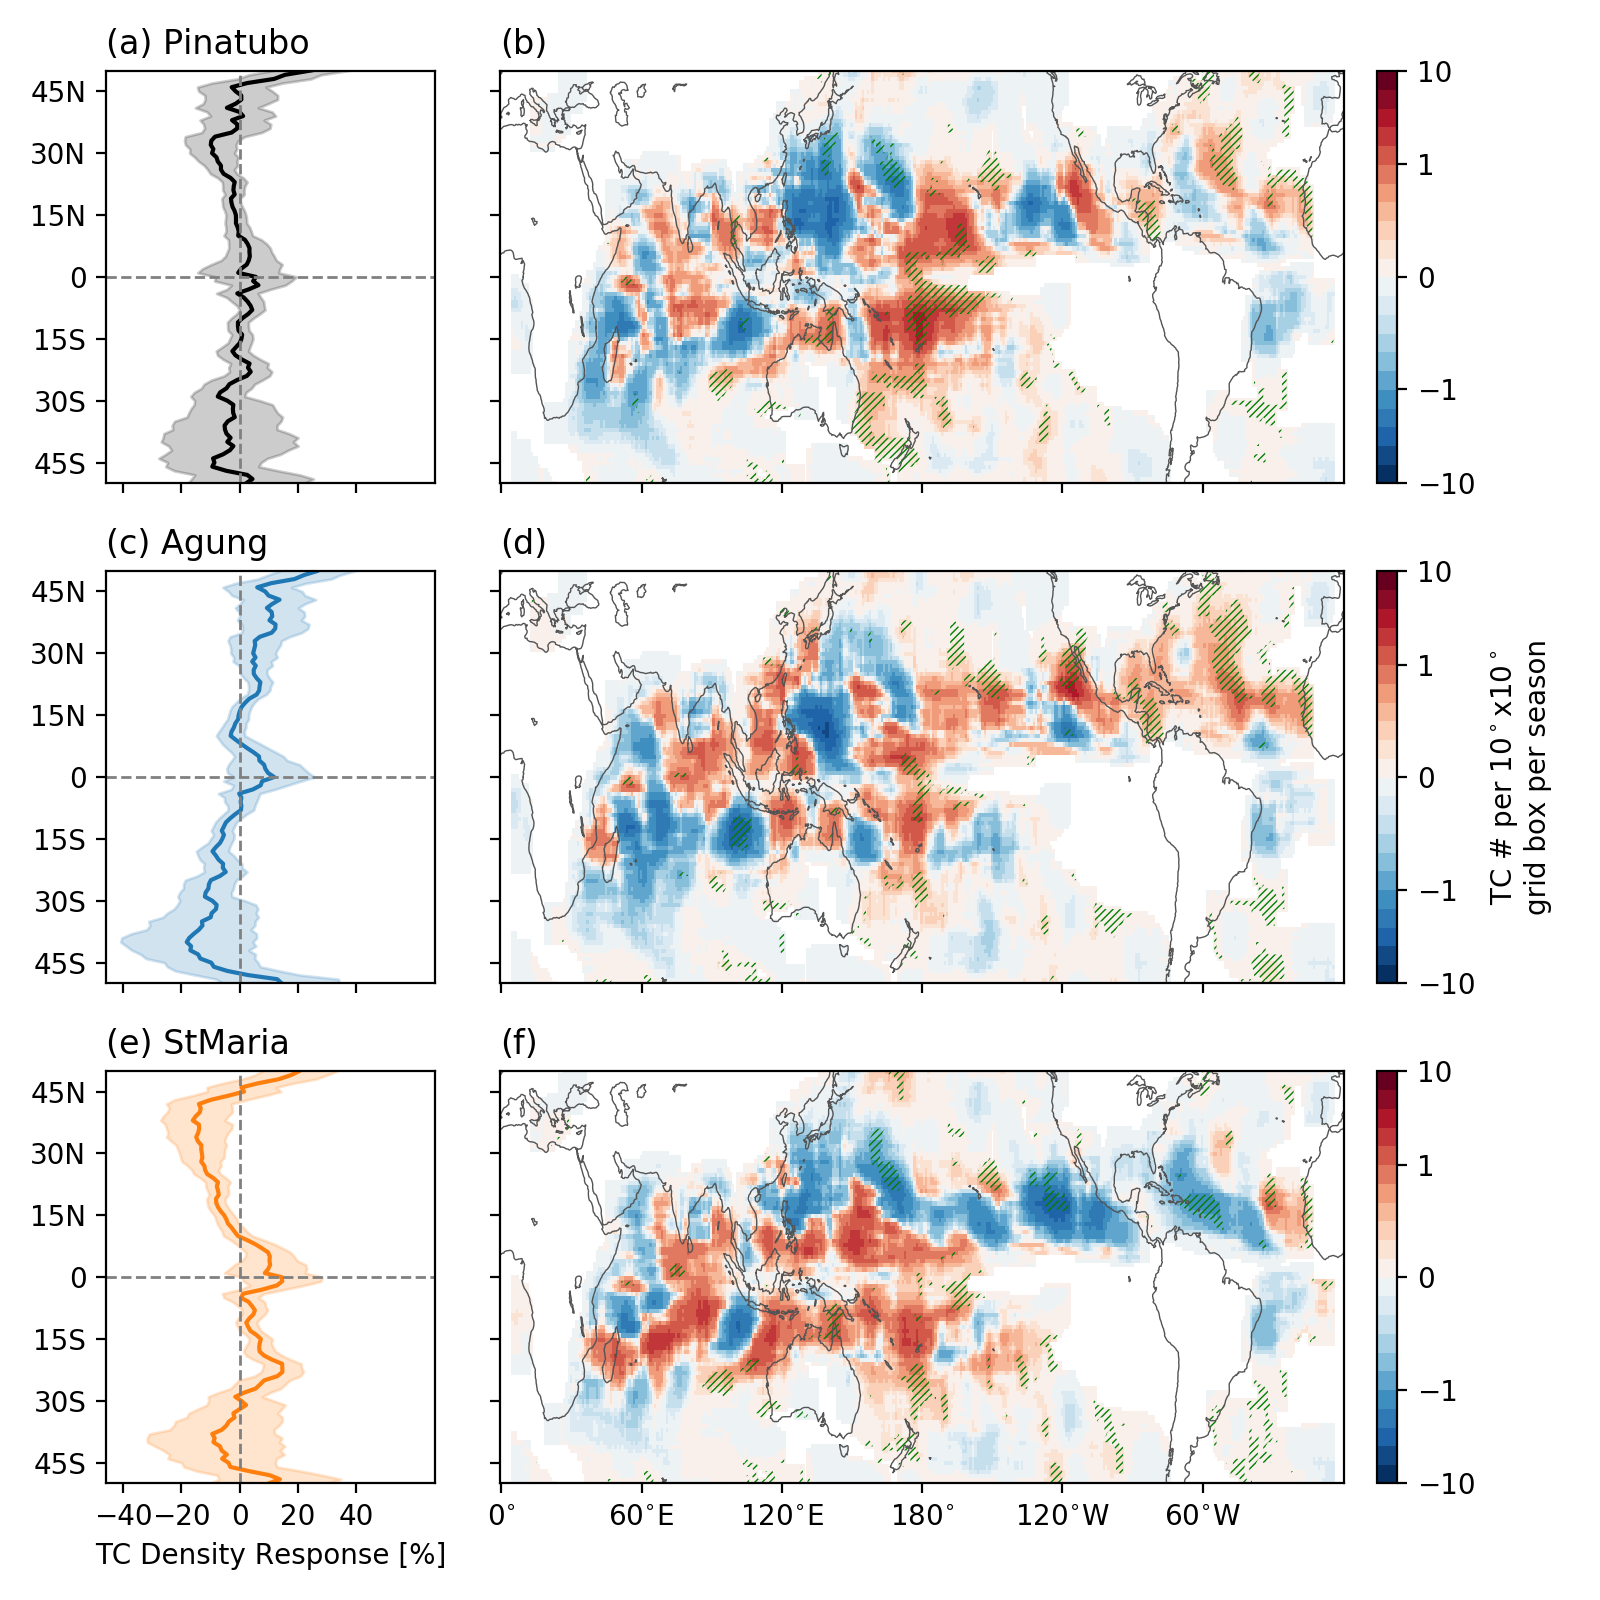

In [361]:
# fig revision_1 spread 3x2 subplots relative
def expand_ax(ax=None, scale=1.5):
    if ax is None:
        ax = plt.gca()
    x0, y0, w, h = ax.get_position().bounds
    ax.set_position([x0-w*(scale-1), y0, w*scale, h])
def shrink_ax(ax=None, scale=0.6):
    if ax is None:
        ax = plt.gca()
    x0, y0, w, h = ax.get_position().bounds
    ax.set_position([x0, y0, w*scale, h])
fig, axes = plt.subplots(3, 2, figsize=(8, 8), sharey=True, sharex='col')
n_years = 3
lv = 10**np.arange(-1, 1.1, .2)
levels = list(-lv[-1::-1]) + [0,] + list(lv)
# levels = np.arange(-100, 101, 20)
coastline_width = .5
cbar_ticks = [-10, -1, 0, 1, 10]
# cbar_ticks = None

aspect = 1/120

alpha=0.2
hatches = ['/////////']

ax = axes[0, 0]
# plt.sca(ax)
# ax.set_aspect(aspect)
# plt.sca(ax)
volc_name, tag = 'pinatubo', 'Pinatubo'
ts = das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref.isel(time=slice(0, n_years)).mean(['en', 'time'])) \
    .rolling(lon=10, center=True).sum() \
    .rolling(lat=10, center=True).sum() \
    .pipe(func_per_season) \
    .mean('lon').pipe(lambda x: x/mean_value*100)
ts.plot(ax=ax, y='lat', label=tag, lw=1.5, color='k')
ax.fill_betweenx(y=ts.lat, x1=ts-spread/mean_value*100, x2=ts+spread/mean_value*100, color='k', alpha=alpha)
ax.autoscale()
ax.set_ylim(-50, 50)
ax.set_ylabel('')
# ax.grid('on')
ax.set_title(f'(a) {tag}', loc='left')
# ax.set_xlabel('TC density')
# ax.set_xlim(-9,5)
# yticks2lat(np.arange(-45,46,15))
# yticks2lat(np.arange(-30,31,30))
ax.set_yticks(range(-45,46,15))
ax.axhline(0, color='gray', lw=1, ls='--')
ax.axvline(0, color='gray', lw=1, ls='--')


ax = axes[1, 0]
# plt.sca(ax)
# ax.set_aspect(aspect)
# plt.sca(ax)
volc_name, tag = 'agung', 'Agung'
ts = das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref.isel(time=slice(0, n_years)).mean(['en', 'time'])) \
    .rolling(lon=10, center=True).sum() \
    .rolling(lat=10, center=True).sum() \
    .pipe(func_per_season) \
    .mean('lon').pipe(lambda x: x/mean_value*100)
ts.plot(ax=ax, y='lat', label=tag, lw=1.5, color='C0')
ax.fill_betweenx(y=ts.lat, x1=ts-spread/mean_value*100, x2=ts+spread/mean_value*100, color='C0', alpha=alpha)
ax.autoscale()
ax.set_ylim(-50, 50)
ax.set_ylabel('')
# ax.grid('on')
ax.set_title(f'(c) {tag}', loc='left')
# ax.set_xlabel('TC density')
# ax.set_xlim(-9,5)
# yticks2lat(np.arange(-45,46,15))
# yticks2lat(np.arange(-30,31,30))
ax.set_yticks(range(-45,46,15))
ax.axhline(0, color='gray', lw=1, ls='--')
ax.axvline(0, color='gray', lw=1, ls='--')

ax = axes[2, 0]
# plt.sca(ax)
# ax.set_aspect(aspect)
# plt.sca(ax)
volc_name, tag = 'stmaria', 'StMaria'
ts = das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref.isel(time=slice(0, n_years)).mean(['en', 'time'])) \
    .rolling(lon=10, center=True).sum() \
    .rolling(lat=10, center=True).sum() \
    .pipe(func_per_season) \
    .mean('lon').pipe(lambda x: x/mean_value*100)
ts.plot(ax=ax, y='lat', label=tag, lw=1.5, color='C1')
ax.fill_betweenx(y=ts.lat, x1=ts-spread/mean_value*100, x2=ts+spread/mean_value*100, color='C1', alpha=alpha)
# ax.legend(loc='lower left', bbox_to_anchor=(-.03,-.05))
ax.autoscale()
ax.set_ylim(-50, 50)
ax.set_ylabel('')
# ax.grid('on')
ax.set_title(f'(e) {tag}', loc='left')
ax.set_xlabel('TC Density Response [%]')
# ax.set_xlim(-9,5)
# yticks2lat(np.arange(-30,31,30))
ax.set_yticks(range(-45,46,15))
ax.axhline(0, color='gray', lw=1, ls='--')
ax.axvline(0, color='gray', lw=1, ls='--')
ax.set_xticks(range(-40, 41, 20))

ax = axes[0, 1]
volc_name = 'pinatubo'
da = das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref.isel(time=slice(0, n_years)).mean(['en', 'time'])).pipe(lambda x: x/4)
da = xr.concat([da.sel(lon=slice(0, 180)), da.sel(lon=slice(-179, 0))], dim='lon')
da['lon'] = np.arange(0, 361)
da = da.rolling(lon=10, center=True).sum() \
    .rolling(lat=10, center=True).sum()
L = np.abs(da) > spread_map
L = L & (spread_map>0)
da.where(spread_map>0).plot(ax=ax, levels=levels, cbar_kwargs={'ticks': cbar_ticks}, rasterized=True)
da.where(L).pipe(lambda x: x*0).plot.contourf(ax=ax, colors='none', hatches=hatches, 
                                              add_colorbar=False)
mapplot(ax=ax, lon=da.lon, lat=(-50, 50), linewidth=coastline_width)
ax.set_xlabel('')
ax.set_ylabel('')
plt.title('(b)', loc='left')

ax = axes[1, 1]
volc_name = 'agung'
da = das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref.isel(time=slice(0, n_years)).mean(['en', 'time'])).pipe(lambda x: x/4)
da = xr.concat([da.sel(lon=slice(0, 180)), da.sel(lon=slice(-179, 0))], dim='lon')
da['lon'] = np.arange(0, 361)
da = da.rolling(lon=10, center=True).sum() \
    .rolling(lat=10, center=True).sum()
L = np.abs(da) > spread_map
L = L & (spread_map>0)
da.where(spread_map>0).rename('TC # per 10$^\circ$x10$^\circ$ grid box per season').plot(ax=ax, levels=levels, cbar_kwargs={'ticks': cbar_ticks}, rasterized=True)
da.where(L).pipe(lambda x: x*0).plot.contourf(ax=ax, colors='none', hatches=hatches, 
                                              add_colorbar=False)
mapplot(ax=ax, lon=da.lon, lat=(-50, 50), linewidth=coastline_width)
ax.set_xlabel('')
ax.set_ylabel('')
plt.title('(d)', loc='left')



ax = axes[2, 1]
plt.sca(ax)
volc_name = 'stmaria'
da = das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref.isel(time=slice(0, n_years)).mean(['en', 'time'])).pipe(lambda x: x/4)
da = xr.concat([da.sel(lon=slice(0, 180)), da.sel(lon=slice(-179, 0))], dim='lon')
da['lon'] = np.arange(0, 361)
da = da.rolling(lon=10, center=True).sum() \
    .rolling(lat=10, center=True).sum()
L = np.abs(da) > spread_map
L = L & (spread_map>0)
da.where(spread_map>0).plot(ax=ax, levels=levels, cbar_kwargs={'ticks': cbar_ticks}, rasterized=True)
da.where(L).pipe(lambda x: x*0).plot.contourf(ax=ax, colors='none', hatches=hatches, 
                                              add_colorbar=False)
mapplot(ax=ax, lon=da.lon, lat=(-50, 50), linewidth=coastline_width)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticks(np.arange(-45,46,15))
ax.set_yticklabels(['45S', '30S', '15S', '0', '15N', '30N', '45N'])
plt.title('(f)', loc='left')
# yticks2lat(np.arange(-45,46,15))



plt.tight_layout()
for ax in axes[:, 0]:
    axscale(ax, right=-0.5)
for ax in axes[:, 1]:
    axscale(ax, left=0.6)

figname = 'figs/fig_tc_percent.pdf'
plt.savefig(figname)

<IPython.core.display.Javascript object>


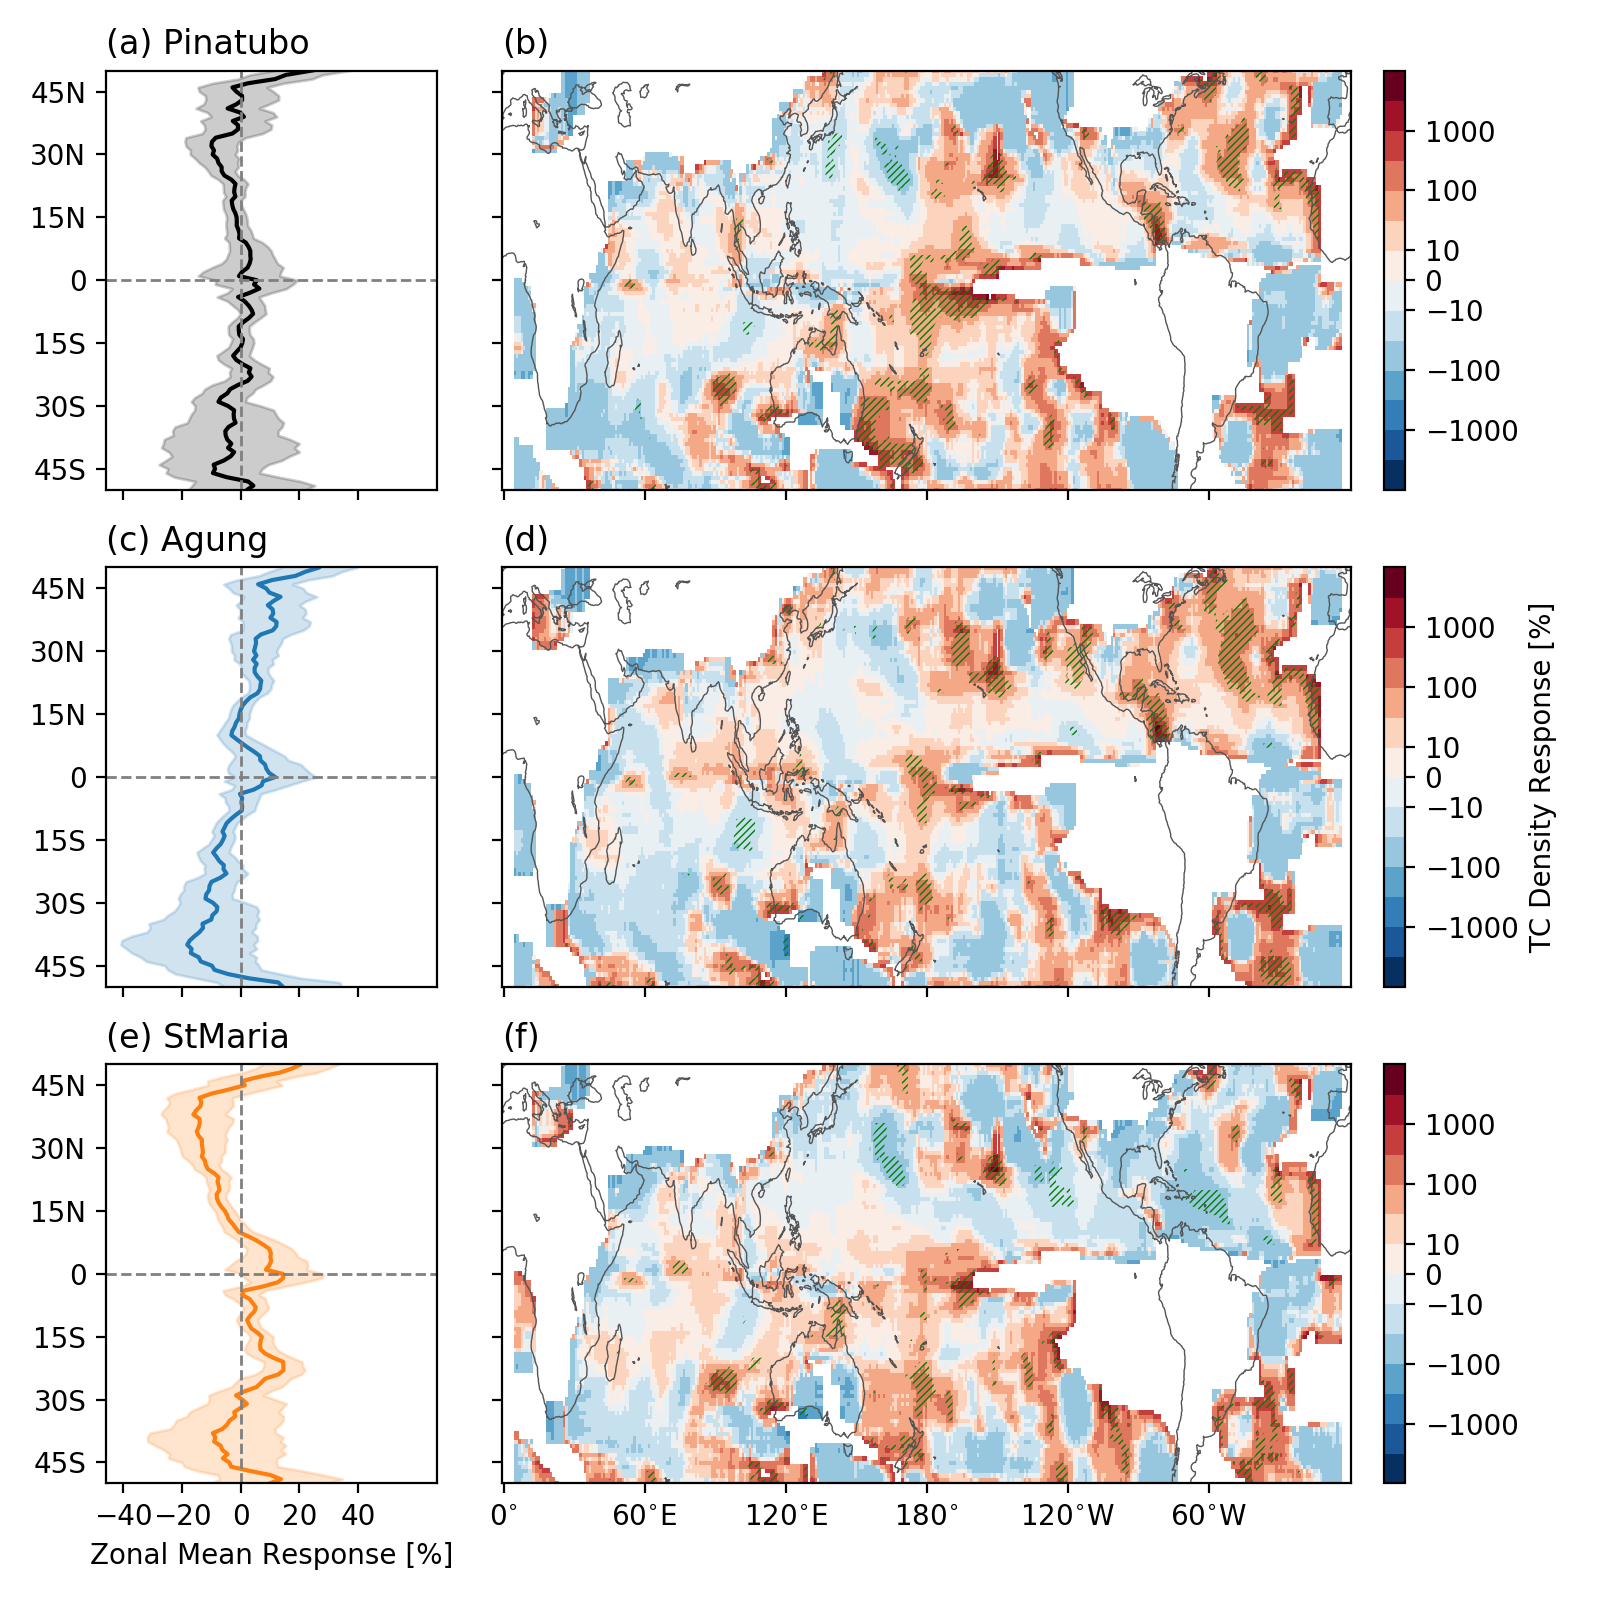

In [360]:
# fig revision_1 spread 3x2 subplots relative both
fig, axes = plt.subplots(3, 2, figsize=(8, 8), sharey=True, sharex='col')
n_years = 3
lv = 10**np.arange(1, 4.1, .5)
levels = list(-lv[-1::-1]) + [0,] + list(lv)
# levels = np.arange(-100, 101, 20)
coastline_width = .5
cbar_ticks = [-1000, -100, -10, 0, 10, 100, 1000]
# cbar_ticks = None

# aspect = 1/120

alpha=0.2
hatches = ['/////////']

ax = axes[0, 0]
# plt.sca(ax)
# ax.set_aspect(aspect)
# plt.sca(ax)
volc_name, tag = 'pinatubo', 'Pinatubo'
ts = das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref.isel(time=slice(0, n_years)).mean(['en', 'time'])) \
    .rolling(lon=10, center=True).sum() \
    .rolling(lat=10, center=True).sum() \
    .pipe(func_per_season) \
    .mean('lon').pipe(lambda x: x/mean_value*100)
ts.plot(ax=ax, y='lat', label=tag, lw=1.5, color='k')
ax.fill_betweenx(y=ts.lat, x1=ts-spread/mean_value*100, x2=ts+spread/mean_value*100, color='k', alpha=alpha)
ax.autoscale()
ax.set_ylim(-50, 50)
ax.set_ylabel('')
# ax.grid('on')
ax.set_title(f'(a) {tag}', loc='left')
# ax.set_xlabel('TC density')
# ax.set_xlim(-9,5)
# yticks2lat(np.arange(-45,46,15))
# yticks2lat(np.arange(-30,31,30))
ax.set_yticks(range(-45,46,15))
ax.axhline(0, color='gray', lw=1, ls='--')
ax.axvline(0, color='gray', lw=1, ls='--')


ax = axes[1, 0]
# plt.sca(ax)
# ax.set_aspect(aspect)
# plt.sca(ax)
volc_name, tag = 'agung', 'Agung'
ts = das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref.isel(time=slice(0, n_years)).mean(['en', 'time'])) \
    .rolling(lon=10, center=True).sum() \
    .rolling(lat=10, center=True).sum() \
    .pipe(func_per_season) \
    .mean('lon').pipe(lambda x: x/mean_value*100)
ts.plot(ax=ax, y='lat', label=tag, lw=1.5, color='C0')
ax.fill_betweenx(y=ts.lat, x1=ts-spread/mean_value*100, x2=ts+spread/mean_value*100, color='C0', alpha=alpha)
ax.autoscale()
ax.set_ylim(-50, 50)
ax.set_ylabel('')
# ax.grid('on')
ax.set_title(f'(c) {tag}', loc='left')
# ax.set_xlabel('TC density')
# ax.set_xlim(-9,5)
# yticks2lat(np.arange(-45,46,15))
# yticks2lat(np.arange(-30,31,30))
ax.set_yticks(range(-45,46,15))
ax.axhline(0, color='gray', lw=1, ls='--')
ax.axvline(0, color='gray', lw=1, ls='--')

ax = axes[2, 0]
# plt.sca(ax)
# ax.set_aspect(aspect)
# plt.sca(ax)
volc_name, tag = 'stmaria', 'StMaria'
ts = das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref.isel(time=slice(0, n_years)).mean(['en', 'time'])) \
    .rolling(lon=10, center=True).sum() \
    .rolling(lat=10, center=True).sum() \
    .pipe(func_per_season) \
    .mean('lon').pipe(lambda x: x/mean_value*100)
ts.plot(ax=ax, y='lat', label=tag, lw=1.5, color='C1')
ax.fill_betweenx(y=ts.lat, x1=ts-spread/mean_value*100, x2=ts+spread/mean_value*100, color='C1', alpha=alpha)
# ax.legend(loc='lower left', bbox_to_anchor=(-.03,-.05))
ax.autoscale()
ax.set_ylim(-50, 50)
ax.set_ylabel('')
# ax.grid('on')
ax.set_title(f'(e) {tag}', loc='left')
ax.set_xlabel('Zonal Mean Response [%]')
# ax.set_xlim(-9,5)
# yticks2lat(np.arange(-30,31,30))
ax.set_yticks(range(-45,46,15))
ax.axhline(0, color='gray', lw=1, ls='--')
ax.axvline(0, color='gray', lw=1, ls='--')
ax.set_xticks(range(-40, 41, 20))

ax = axes[0, 1]
volc_name = 'pinatubo'
da = das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref.isel(time=slice(0, n_years)).mean(['en', 'time'])).pipe(lambda x: x/4)
da = xr.concat([da.sel(lon=slice(0, 180)), da.sel(lon=slice(-179, 0))], dim='lon')
da['lon'] = np.arange(0, 361)
da = da.rolling(lon=10, center=True).sum() \
    .rolling(lat=10, center=True).sum()
L = np.abs(da) > spread_map
L = L & (spread_map>0)
da.pipe(lambda x: x/mean_value_map*100).where(spread_map>0).plot(ax=ax, levels=levels, cbar_kwargs={'ticks': cbar_ticks}, rasterized=True)
da.where(L).pipe(lambda x: x*0).plot.contourf(ax=ax, colors='none', hatches=hatches, 
                                              add_colorbar=False)
mapplot(ax=ax, lon=da.lon, lat=(-50, 50), linewidth=coastline_width)
ax.set_xlabel('')
ax.set_ylabel('')
plt.title('(b)', loc='left')

ax = axes[1, 1]
volc_name = 'agung'
da = das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref.isel(time=slice(0, n_years)).mean(['en', 'time'])).pipe(lambda x: x/4)
da = xr.concat([da.sel(lon=slice(0, 180)), da.sel(lon=slice(-179, 0))], dim='lon')
da['lon'] = np.arange(0, 361)
da = da.rolling(lon=10, center=True).sum() \
    .rolling(lat=10, center=True).sum()
L = np.abs(da) > spread_map
L = L & (spread_map>0)
da.pipe(lambda x: x/mean_value_map*100).where(spread_map>0).rename('TC Density Response [%]').plot(ax=ax, levels=levels, cbar_kwargs={'ticks': cbar_ticks}, rasterized=True)
da.where(L).pipe(lambda x: x*0).plot.contourf(ax=ax, colors='none', hatches=hatches, 
                                              add_colorbar=False)
mapplot(ax=ax, lon=da.lon, lat=(-50, 50), linewidth=coastline_width)
ax.set_xlabel('')
ax.set_ylabel('')
plt.title('(d)', loc='left')



ax = axes[2, 1]
plt.sca(ax)
volc_name = 'stmaria'
da = das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref.isel(time=slice(0, n_years)).mean(['en', 'time'])).pipe(lambda x: x/4)
da = xr.concat([da.sel(lon=slice(0, 180)), da.sel(lon=slice(-179, 0))], dim='lon')
da['lon'] = np.arange(0, 361)
da = da.rolling(lon=10, center=True).sum() \
    .rolling(lat=10, center=True).sum()
L = np.abs(da) > spread_map
L = L & (spread_map>0)
da.pipe(lambda x: x/mean_value_map*100).where(spread_map>0).plot(ax=ax, levels=levels, cbar_kwargs={'ticks': cbar_ticks}, rasterized=True)
da.where(L).pipe(lambda x: x*0).plot.contourf(ax=ax, colors='none', hatches=hatches, 
                                              add_colorbar=False)
mapplot(ax=ax, lon=da.lon, lat=(-50, 50), linewidth=coastline_width)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticks(np.arange(-45,46,15))
ax.set_yticklabels(['45S', '30S', '15S', '0', '15N', '30N', '45N'])
plt.title('(f)', loc='left')
# yticks2lat(np.arange(-45,46,15))



plt.tight_layout()
for ax in axes[:, 0]:
    axscale(ax, right=-0.5)
for ax in axes[:, 1]:
    axscale(ax, left=0.6)
    
figname = 'figs/fig_tc_percent_map.pdf'
plt.savefig(figname)

<IPython.core.display.Javascript object>


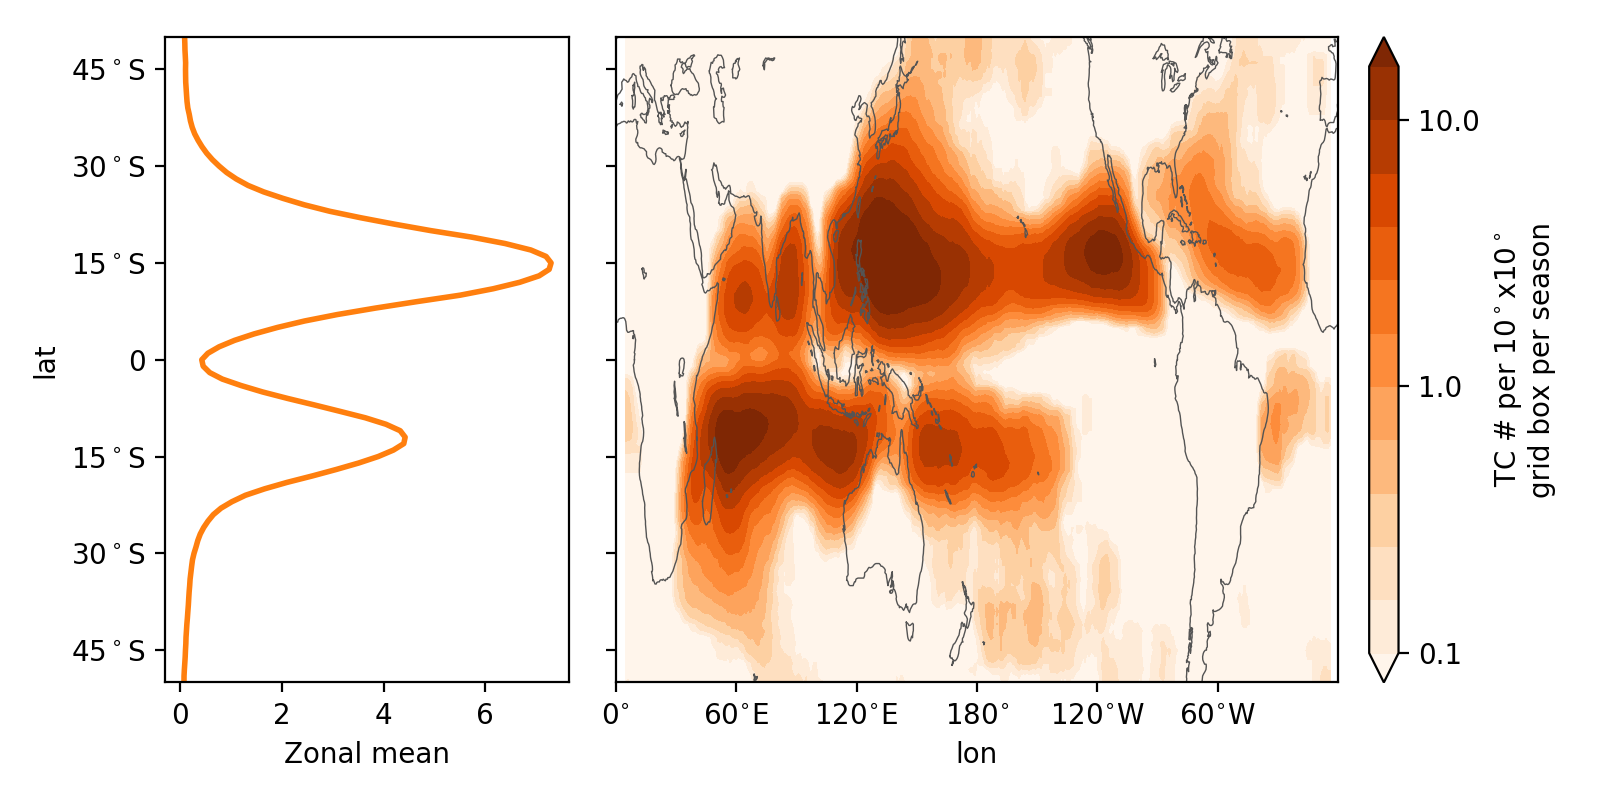

In [365]:
# TC density in control run
fig, axes = plt.subplots(1, 2, figsize=(8,4), sharey=True)

ax = axes[0]
mean_value_map.mean('lon').plot(ax=ax, y='lat', color='C1')
plt.autoscale()
ax.set_ylabel('lat')
ax.set_xlabel('Zonal mean')

ax = axes[1]
lvs = 10**np.arange(-1, 1.3, .2)
mean_value_map.rename('TC # per 10$^\circ$x10$^\circ$ grid box per season') \
    .plot.contourf(ax=ax, robust=True, levels=lvs, cbar_kwargs={'ticks': lvs[0:-1:5]}, cmap='Oranges')
mapplot(coastlines_width=1/2)
plt.ylim(-50, 50)
plt.ylabel('')
ax.set_yticks(range(-45, 46, 15))
ax.set_yticklabels([f'{-n}$^\circ$S' for n in range(-45,0,15)]
                  + ['0']
                  + [f'{n}$^\circ$S' for n in range(15, 46, 15)])



plt.tight_layout()
axscale(axes[0], right=-0.35)
axscale(axes[1], left=0.45)

plt.savefig('figs/fig_tc_ctl.pdf')

<IPython.core.display.Javascript object>


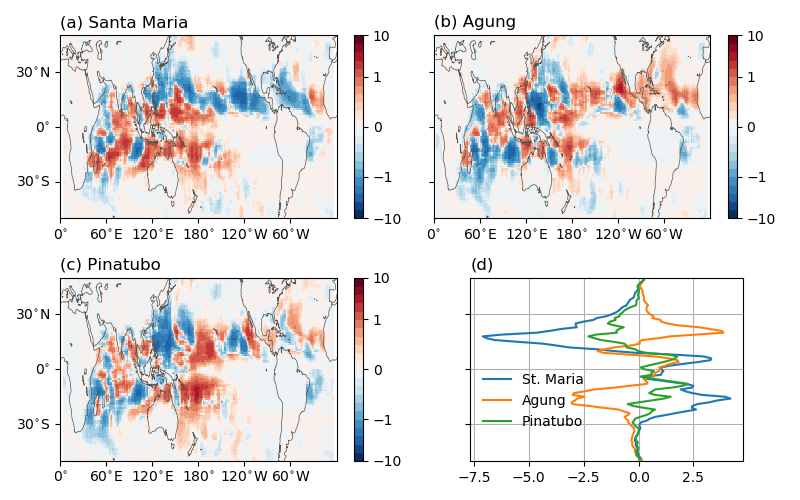

/tigress/wenchang/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [36]:
# fig: 9x9 grids
fig, axes = plt.subplots(2, 2, figsize=(8, 5), sharey=True)
n_years = 3
lv = 10**np.arange(-1, 1.1, .2)
levels = list(-lv[-1::-1]) + [0,] + list(lv)
coastline_width = .5
cbar_ticks = [-10, -1, 0, 1, 10]

ax = axes[0, 0]
volc_name = 'stmaria'
da = das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref.isel(time=slice(0, n_years)).mean(['en', 'time'])).pipe(lambda x: x*100/4)
da = xr.concat([da.sel(lon=slice(0, 180)), da.sel(lon=slice(-179, 0))], dim='lon')
da['lon'] = np.arange(0, 361)
da.rolling(lon=9, center=True).mean() \
    .rolling(lat=9, center=True).mean() \
    .plot(ax=ax, levels=levels, cbar_kwargs={'ticks': cbar_ticks}, rasterized=True)
mapplot(ax=ax, lon=da.lon, lat=(-50, 50), linewidth=coastline_width)
ax.set_xlabel('')
ax.set_ylabel('')
plt.title('(a) Santa Maria', loc='left')

ax = axes[0, 1]
volc_name = 'agung'
da = das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref.isel(time=slice(0, n_years)).mean(['en', 'time'])).pipe(lambda x: x*100/4)
da = xr.concat([da.sel(lon=slice(0, 180)), da.sel(lon=slice(-179, 0))], dim='lon')
da['lon'] = np.arange(0, 361)
da.rolling(lon=9, center=True).mean() \
    .rolling(lat=9, center=True).mean() \
    .plot(ax=ax, levels=levels, cbar_kwargs={'ticks': cbar_ticks}, rasterized=True)
mapplot(ax=ax, lon=da.lon, lat=(-50, 50), linewidth=coastline_width)
ax.set_xlabel('')
ax.set_ylabel('')
plt.title('(b) Agung', loc='left')

ax = axes[1, 0]
volc_name = 'pinatubo'
da = das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref.isel(time=slice(0, n_years)).mean(['en', 'time'])).pipe(lambda x: x*100/4)
da = xr.concat([da.sel(lon=slice(0, 180)), da.sel(lon=slice(-179, 0))], dim='lon')
da['lon'] = np.arange(0, 361)
da.rolling(lon=9, center=True).mean() \
    .rolling(lat=9, center=True).mean() \
    .plot(ax=ax, levels=levels, cbar_kwargs={'ticks': cbar_ticks}, rasterized=True)
mapplot(ax=ax, lon=da.lon, lat=(-50, 50), linewidth=coastline_width)
ax.set_xlabel('')
ax.set_ylabel('')
plt.title('(c) Pinatubo', loc='left')

ax = axes[1, 1]
ax.set_aspect(1/12)
plt.sca(ax)
volc_name, tag = 'stmaria', 'St. Maria'
das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref.isel(time=slice(0, n_years)).mean(['en', 'time'])) \
    .sum('lon') \
    .rolling(lat=11, center=True).mean() \
    .plot(ax=ax, y='lat', label=tag, lw=1.5)
volc_name, tag = 'agung', 'Agung'
das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref.isel(time=slice(0, n_years)).mean(['en', 'time'])) \
    .sum('lon') \
    .rolling(lat=11, center=True).mean() \
    .plot(ax=ax, y='lat', label=tag, lw=1.5)
volc_name, tag = 'pinatubo', 'Pinatubo'
das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref.isel(time=slice(0, n_years)).mean(['en', 'time'])) \
    .sum('lon') \
    .rolling(lat=11, center=True).mean() \
    .plot(ax=ax, y='lat', label=tag, lw=1.5)
plt.legend(loc='upper left', bbox_to_anchor=(0,.55))
ax.set_ylim(-50, 50)
ax.set_ylabel('')
plt.grid('on')
plt.title('(d)', loc='left')


plt.tight_layout()

figname = 'figs/fig_tc_9x9.pdf'
plt.savefig(figname)

## 200 CTL years

<IPython.core.display.Javascript object>


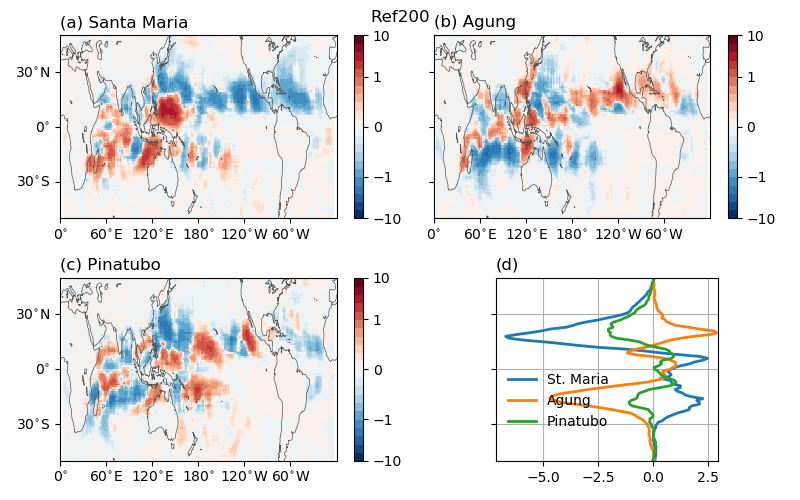

/tigress/wenchang/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [18]:
# fig: ref200
fig, axes = plt.subplots(2, 2, figsize=(8, 5), sharey=True)
n_years = 3
lv = 10**np.arange(-1, 1.1, .2)
levels = list(-lv[-1::-1]) + [0,] + list(lv)
coastline_width = .5
cbar_ticks = [-10, -1, 0, 1, 10]

ax = axes[0, 0]
volc_name = 'stmaria'
da = das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref200).pipe(lambda x: x*100/4)
da = xr.concat([da.sel(lon=slice(0, 180)), da.sel(lon=slice(-179, 0))], dim='lon')
da['lon'] = np.arange(0, 361)
da.rolling(lon=9, center=True).mean() \
    .rolling(lat=9, center=True).mean() \
    .plot(ax=ax, levels=levels, cbar_kwargs={'ticks': cbar_ticks}, rasterized=True)
mapplot(ax=ax, lon=da.lon, lat=(-50, 50), linewidth=coastline_width)
ax.set_xlabel('')
ax.set_ylabel('')
plt.title('(a) Santa Maria', loc='left')

ax = axes[0, 1]
volc_name = 'agung'
da = das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref200).pipe(lambda x: x*100/4)
da = xr.concat([da.sel(lon=slice(0, 180)), da.sel(lon=slice(-179, 0))], dim='lon')
da['lon'] = np.arange(0, 361)
da.rolling(lon=9, center=True).mean() \
    .rolling(lat=9, center=True).mean() \
    .plot(ax=ax, levels=levels, cbar_kwargs={'ticks': cbar_ticks}, rasterized=True)
mapplot(ax=ax, lon=da.lon, lat=(-50, 50), linewidth=coastline_width)
ax.set_xlabel('')
ax.set_ylabel('')
plt.title('(b) Agung', loc='left')

ax = axes[1, 0]
volc_name = 'pinatubo'
da = das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref200).pipe(lambda x: x*100/4)
da = xr.concat([da.sel(lon=slice(0, 180)), da.sel(lon=slice(-179, 0))], dim='lon')
da['lon'] = np.arange(0, 361)
da.rolling(lon=9, center=True).mean() \
    .rolling(lat=9, center=True).mean() \
    .plot(ax=ax, levels=levels, cbar_kwargs={'ticks': cbar_ticks}, rasterized=True)
mapplot(ax=ax, lon=da.lon, lat=(-50, 50), linewidth=coastline_width)
ax.set_xlabel('')
ax.set_ylabel('')
plt.title('(c) Pinatubo', loc='left')

ax = axes[1, 1]
ax.set_aspect(1/12)
plt.sca(ax)
volc_name, tag = 'stmaria', 'St. Maria'
das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref200) \
    .sum('lon') \
    .rolling(lat=11, center=True).mean() \
    .plot(ax=ax, y='lat', label=tag)
volc_name, tag = 'agung', 'Agung'
das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref200) \
    .sum('lon') \
    .rolling(lat=11, center=True).mean() \
    .plot(ax=ax, y='lat', label=tag)
volc_name, tag = 'pinatubo', 'Pinatubo'
das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref200) \
    .sum('lon') \
    .rolling(lat=11, center=True).mean() \
    .plot(ax=ax, y='lat', label=tag)
plt.legend(loc='upper left', bbox_to_anchor=(0,.55))
ax.set_ylim(-50, 50)
ax.set_ylabel('')
plt.grid('on')
plt.title('(d)', loc='left')

plt.suptitle('Ref200')
plt.tight_layout()

figname = 'figs/fig_tc_ref200.pdf'
plt.savefig(figname)

## foot

<IPython.core.display.Javascript object>


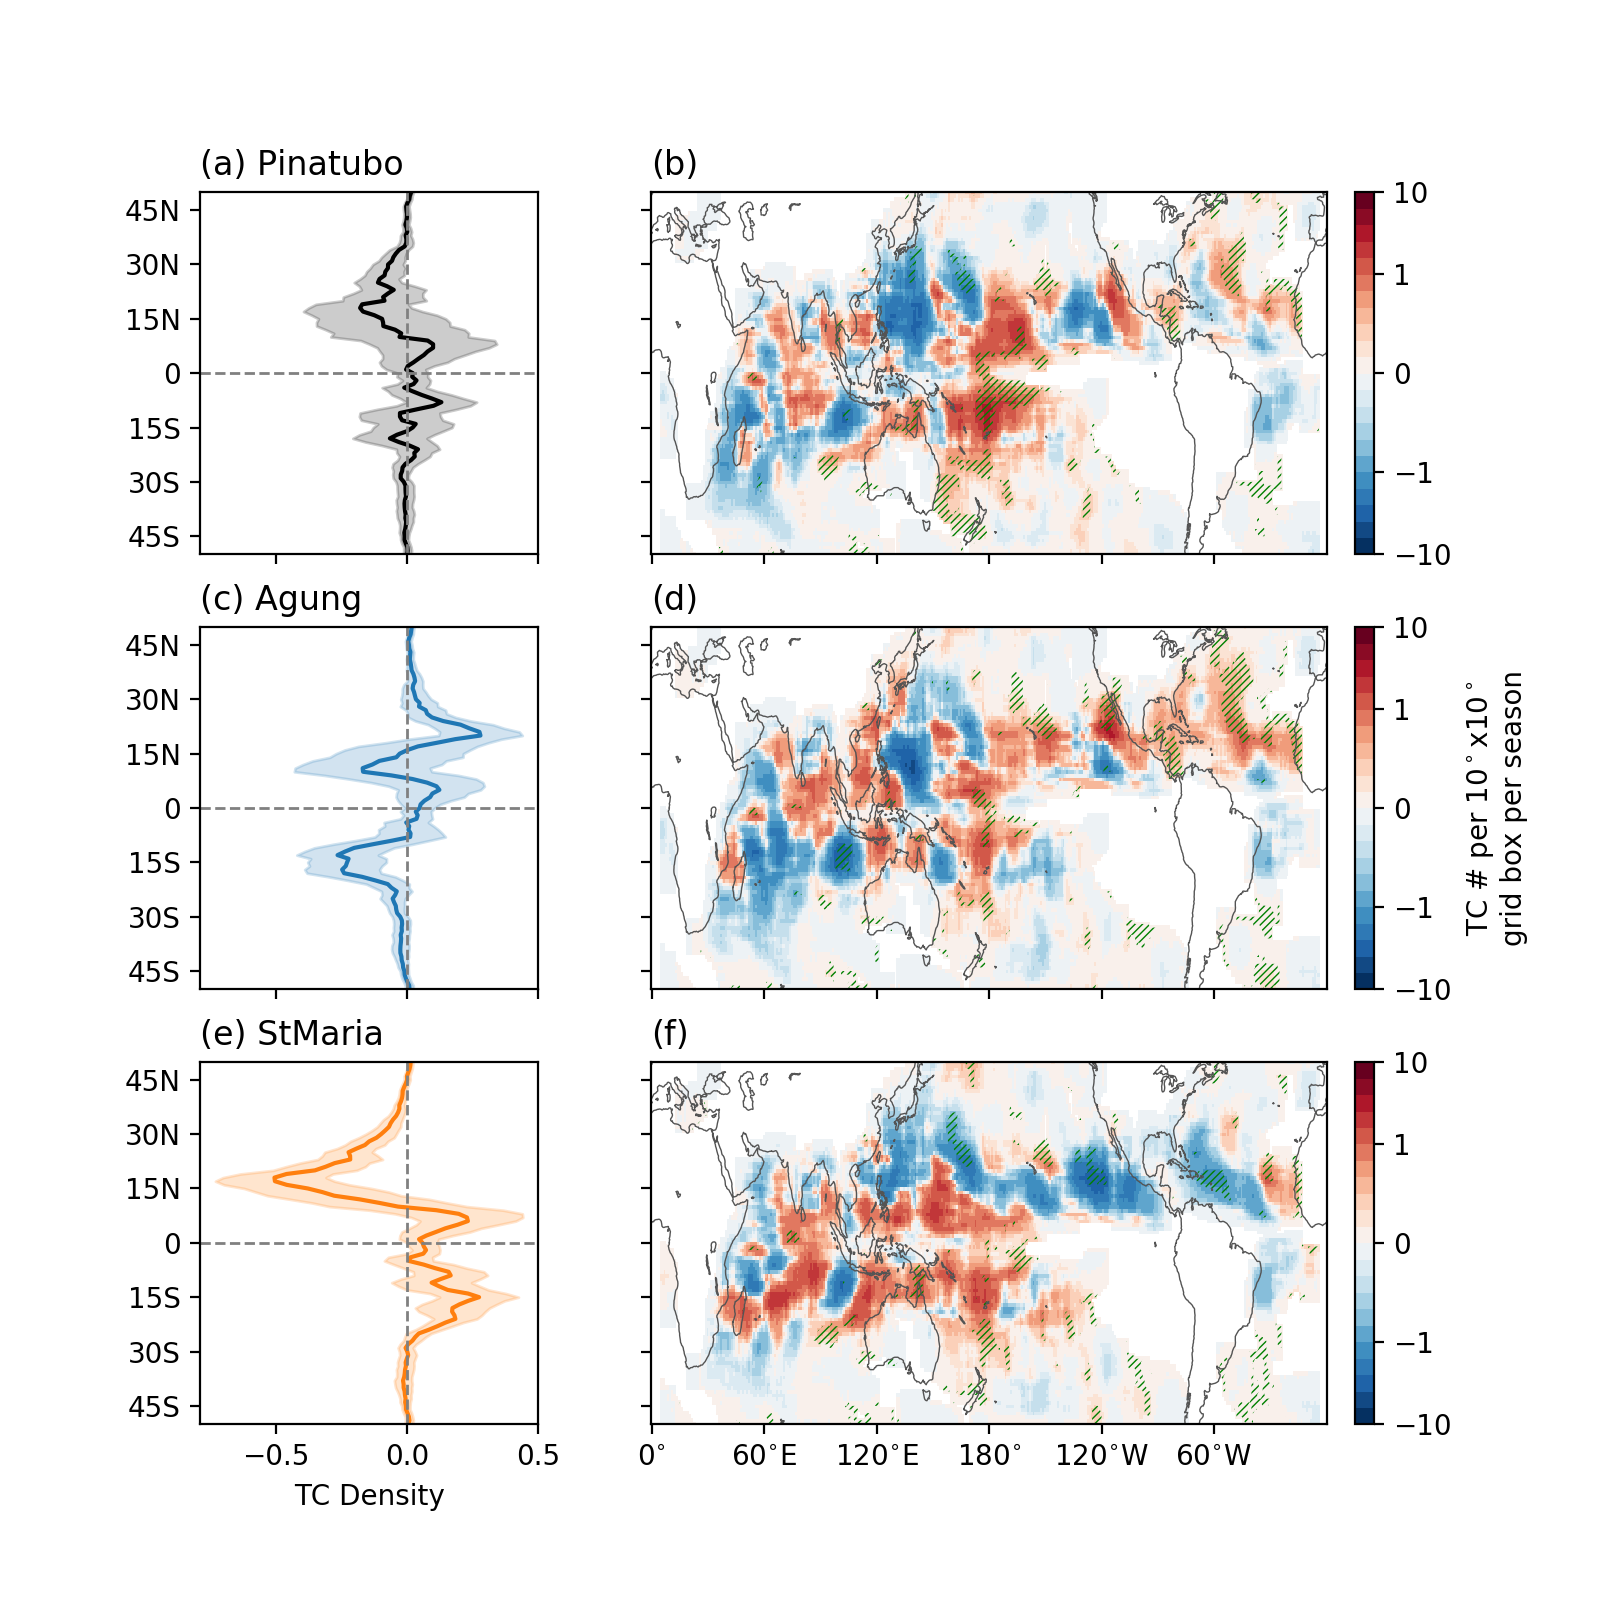

In [212]:
# fig revision_1 spread 3x2 subplots
def expand_ax(ax, scale=1.5):
    x0, y0, w, h = ax.get_position().bounds
    ax.set_position([x0-w*(scale-1), y0, w*scale, h])
def shrink_ax(ax, scale=0.6):
    x0, y0, w, h = ax.get_position().bounds
    ax.set_position([x0, y0, w*scale, h])
fig, axes = plt.subplots(3, 2, figsize=(8, 8), sharey=True, sharex='col')
n_years = 3
lv = 10**np.arange(-1, 1.1, .2)
levels = list(-lv[-1::-1]) + [0,] + list(lv)
coastline_width = .5
cbar_ticks = [-10, -1, 0, 1, 10]

aspect = 1/120

alpha=0.2
hatches = ['/////////']

ax = axes[0, 0]
# plt.sca(ax)
# ax.set_aspect(aspect)
# plt.sca(ax)
volc_name, tag = 'pinatubo', 'Pinatubo'
ts = das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref.isel(time=slice(0, n_years)).mean(['en', 'time'])) \
    .rolling(lon=10, center=True).sum() \
    .rolling(lat=10, center=True).sum() \
    .pipe(func_per_season) \
    .mean('lon')
ts.plot(ax=ax, y='lat', label=tag, lw=1.5, color='k')
ax.fill_betweenx(y=ts.lat, x1=ts-spread, x2=ts+spread, color='k', alpha=alpha)
ax.autoscale()
ax.set_ylim(-50, 50)
ax.set_ylabel('')
# ax.grid('on')
ax.set_title(f'(a) {tag}', loc='left')
# ax.set_xlabel('TC density')
# ax.set_xlim(-9,5)
# yticks2lat(np.arange(-45,46,15))
# yticks2lat(np.arange(-30,31,30))
ax.set_yticks(range(-45,46,15))
ax.axhline(0, color='gray', lw=1, ls='--')
ax.axvline(0, color='gray', lw=1, ls='--')
shrink_ax(ax)


ax = axes[1, 0]
# plt.sca(ax)
# ax.set_aspect(aspect)
# plt.sca(ax)
volc_name, tag = 'agung', 'Agung'
ts = das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref.isel(time=slice(0, n_years)).mean(['en', 'time'])) \
    .rolling(lon=10, center=True).sum() \
    .rolling(lat=10, center=True).sum() \
    .pipe(func_per_season) \
    .mean('lon')
ts.plot(ax=ax, y='lat', label=tag, lw=1.5, color='C0')
ax.fill_betweenx(y=ts.lat, x1=ts-spread, x2=ts+spread, color='C0', alpha=alpha)
ax.autoscale()
ax.set_ylim(-50, 50)
ax.set_ylabel('')
# ax.grid('on')
ax.set_title(f'(c) {tag}', loc='left')
# ax.set_xlabel('TC density')
# ax.set_xlim(-9,5)
# yticks2lat(np.arange(-45,46,15))
# yticks2lat(np.arange(-30,31,30))
ax.set_yticks(range(-45,46,15))
ax.axhline(0, color='gray', lw=1, ls='--')
ax.axvline(0, color='gray', lw=1, ls='--')
shrink_ax(ax)

ax = axes[2, 0]
# plt.sca(ax)
# ax.set_aspect(aspect)
# plt.sca(ax)
volc_name, tag = 'stmaria', 'StMaria'
ts = das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref.isel(time=slice(0, n_years)).mean(['en', 'time'])) \
    .rolling(lon=10, center=True).sum() \
    .rolling(lat=10, center=True).sum() \
    .pipe(func_per_season) \
    .mean('lon')
ts.plot(ax=ax, y='lat', label=tag, lw=1.5, color='C1')
ax.fill_betweenx(y=ts.lat, x1=ts-spread, x2=ts+spread, color='C1', alpha=alpha)
# ax.legend(loc='lower left', bbox_to_anchor=(-.03,-.05))
ax.autoscale()
ax.set_ylim(-50, 50)
ax.set_ylabel('')
# ax.grid('on')
ax.set_title(f'(e) {tag}', loc='left')
ax.set_xlabel('TC Density')
# ax.set_xlim(-9,5)
# yticks2lat(np.arange(-30,31,30))
ax.set_yticks(range(-45,46,15))
ax.axhline(0, color='gray', lw=1, ls='--')
ax.axvline(0, color='gray', lw=1, ls='--')
shrink_ax(ax)

ax = axes[0, 1]
volc_name = 'pinatubo'
da = das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref.isel(time=slice(0, n_years)).mean(['en', 'time'])).pipe(lambda x: x/4)
da = xr.concat([da.sel(lon=slice(0, 180)), da.sel(lon=slice(-179, 0))], dim='lon')
da['lon'] = np.arange(0, 361)
da = da.rolling(lon=10, center=True).sum() \
    .rolling(lat=10, center=True).sum()
L = np.abs(da) > spread_map
L = L & (spread_map>0)
da.where(spread_map>0).plot(ax=ax, levels=levels, cbar_kwargs={'ticks': cbar_ticks}, rasterized=True)
da.where(L).pipe(lambda x: x*0).plot.contourf(ax=ax, colors='none', hatches=hatches, 
                                              add_colorbar=False)
mapplot(ax=ax, lon=da.lon, lat=(-50, 50), linewidth=coastline_width)
ax.set_xlabel('')
ax.set_ylabel('')
plt.title('(b)', loc='left')
expand_ax(ax)

ax = axes[1, 1]
volc_name = 'agung'
da = das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref.isel(time=slice(0, n_years)).mean(['en', 'time'])).pipe(lambda x: x/4)
da = xr.concat([da.sel(lon=slice(0, 180)), da.sel(lon=slice(-179, 0))], dim='lon')
da['lon'] = np.arange(0, 361)
da = da.rolling(lon=10, center=True).sum() \
    .rolling(lat=10, center=True).sum()
L = np.abs(da) > spread_map
L = L & (spread_map>0)
da.where(spread_map>0).rename('TC # per 10$^\circ$x10$^\circ$ grid box per season').plot(ax=ax, levels=levels, cbar_kwargs={'ticks': cbar_ticks}, rasterized=True)
da.where(L).pipe(lambda x: x*0).plot.contourf(ax=ax, colors='none', hatches=hatches, 
                                              add_colorbar=False)
mapplot(ax=ax, lon=da.lon, lat=(-50, 50), linewidth=coastline_width)
ax.set_xlabel('')
ax.set_ylabel('')
plt.title('(d)', loc='left')
expand_ax(ax)



ax = axes[2, 1]
plt.sca(ax)
volc_name = 'stmaria'
da = das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref.isel(time=slice(0, n_years)).mean(['en', 'time'])).pipe(lambda x: x/4)
da = xr.concat([da.sel(lon=slice(0, 180)), da.sel(lon=slice(-179, 0))], dim='lon')
da['lon'] = np.arange(0, 361)
da = da.rolling(lon=10, center=True).sum() \
    .rolling(lat=10, center=True).sum()
L = np.abs(da) > spread_map
L = L & (spread_map>0)
da.where(spread_map>0).plot(ax=ax, levels=levels, cbar_kwargs={'ticks': cbar_ticks}, rasterized=True)
da.where(L).pipe(lambda x: x*0).plot.contourf(ax=ax, colors='none', hatches=hatches, 
                                              add_colorbar=False)
mapplot(ax=ax, lon=da.lon, lat=(-50, 50), linewidth=coastline_width)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticks(np.arange(-45,46,15))
ax.set_yticklabels(['45S', '30S', '15S', '0', '15N', '30N', '45N'])
plt.title('(f)', loc='left')
# yticks2lat(np.arange(-45,46,15))
expand_ax(ax)



# plt.tight_layout()

figname = 'figs/fig_tc.pdf'
plt.savefig(figname)

In [336]:
%%html
<script src="https://cdn.rawgit.com/parente/4c3e6936d0d7a46fd071/raw/65b816fb9bdd3c28b4ddf3af602bfd6015486383/code_toggle.js">
</script>